# <font color='darkorange'> C03 - Embedding Spaces ( Latent Spaces )

# <font color='darkorange'> 0.0. Imports

In [1]:
import sys
import os

# create a path that points to the parent directory of the current directory
module_path = os.path.abspath(os.path.join('..'))

# check if the absolute path of the parent directory has been added to the system module search path
if module_path not in sys.path:
    sys.path.append(module_path)

os.chdir(module_path)

In [6]:
import re
import warnings
import inflection
import numpy                  as np
import pandas                 as pd
import seaborn                as sns
import matplotlib.pyplot      as plt
from ydata_profiling          import ProfileReport

import umap
from plotly                   import express as px 
from yellowbrick.cluster      import KElbowVisualizer, SilhouetteVisualizer 

from sklearn.decomposition    import PCA
from sklearn.manifold         import TSNE
from sklearn.ensemble         import RandomForestRegressor
from sklearn.preprocessing    import MinMaxScaler
from sklearn.pipeline         import Pipeline
from sklearn.cluster          import KMeans, DBSCAN
from sklearn.mixture          import GaussianMixture
from sklearn.neighbors        import NearestNeighbors
from scipy.cluster.hierarchy  import linkage, fcluster, dendrogram

from sklearn.metrics.cluster  import silhouette_score, silhouette_samples
from sklearn.base             import BaseEstimator, TransformerMixin

## <font color='darkorange'> 0.1. Helper Functions

In [7]:
starts = Starts()
starts.jupyter_settings()

## <font color='darkorange'>0.2. Load Data

In [4]:
# Load Data
data_raw = pd.read_csv("data/raw/Ecommerce.csv", encoding='unicode_escape')

# Drop "Unnamed: 8" column
data_raw = data_raw.drop(columns = "Unnamed: 8")

| Column Name | Description                                            |
|-------------|--------------------------------------------------------|
| InvoiceNo   | Invoice number, a unique identifier for each transaction |
| StockCode   | Product code, a unique identifier for each product       |
| Description | Product description                                     |
| Quantity    | Quantity of products purchased in each transaction      |
| InvoiceDate | Date and time of each transaction                        |
| UnitPrice   | Unit price of each product                              |
| CustomerID  | Customer ID, a unique identifier for each customer       |
| Country     | Country of the customer                                 |


# <font color='darkorange'>1.0. Data Description

In [5]:
df1 = data_raw.copy()
df1.head()

InvoiceNo StockCode                          Description  Quantity InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   29-Nov-16       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6   29-Nov-16       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   29-Nov-16       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   29-Nov-16       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   29-Nov-16       3.39     17850.0  United Kingdom

## <font color='darkorange'>1.1. Rename Columns

In [6]:
# Class responsible for renaming columns. 
# It is inside utils directory
class RenameDataframeColumns_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = self.rename_columns(X)
        
        return X
    
    def rename_columns(self, dataframe):
        # Copy DataFrame
        new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

        # Apply new columns names to DataFrame
        df.columns = new_cols
        
        return df

In [7]:
# Create Pipeline to rename DataFrame
rename_pipe = Pipeline([
    ('rename', pipeline_class.RenameDataframeColumns())])

rename_pipe

Pipeline(steps=[('rename', RenameDataframeColumns())])

In [8]:

# Use Pipeline to rename DataFrame Columns
df1 = rename_pipe.fit_transform(df1)
df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55      17850.0  United Kingdom
1     536365      71053                  WHITE METAL LANTERN         6    29-Nov-16        3.39      17850.0  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16        2.75      17850.0  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6    29-Nov-16        3.39      17850.0  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6    29-Nov-16        3.39      17850.0  United Kingdom

## <font color='darkorange'>1.2. Data Dimensions

In [9]:
starts.data_dimensions(df1)

Number of rows: 541909
Number of cols: 8


## <font color='darkorange'>1.3. Data Checks ( Types and NA )

In [10]:
starts.type_na(df1)

Type  number na percent na
invoice_no     object          0      0.0 %
stock_code     object          0      0.0 %
description    object       1454     0.27 %
quantity        int64          0      0.0 %
invoice_date   object          0      0.0 %
unit_price    float64          0      0.0 %
customer_id   float64     135080    24.93 %
country        object          0      0.0 %

- Invoices without customer id

In [11]:
# Convert date for datetime
df1.invoice_date = pd.to_datetime( df1.invoice_date, format='%d-%b-%y')

# <font color='darkorange'>2.0. Exploratory Data Analysis - Invoices

In [12]:
df2 = df1.copy()

## <font color='darkorange'>2.1. First view

### <font color='darkorange'>2.1.1. Descriptive Statistics

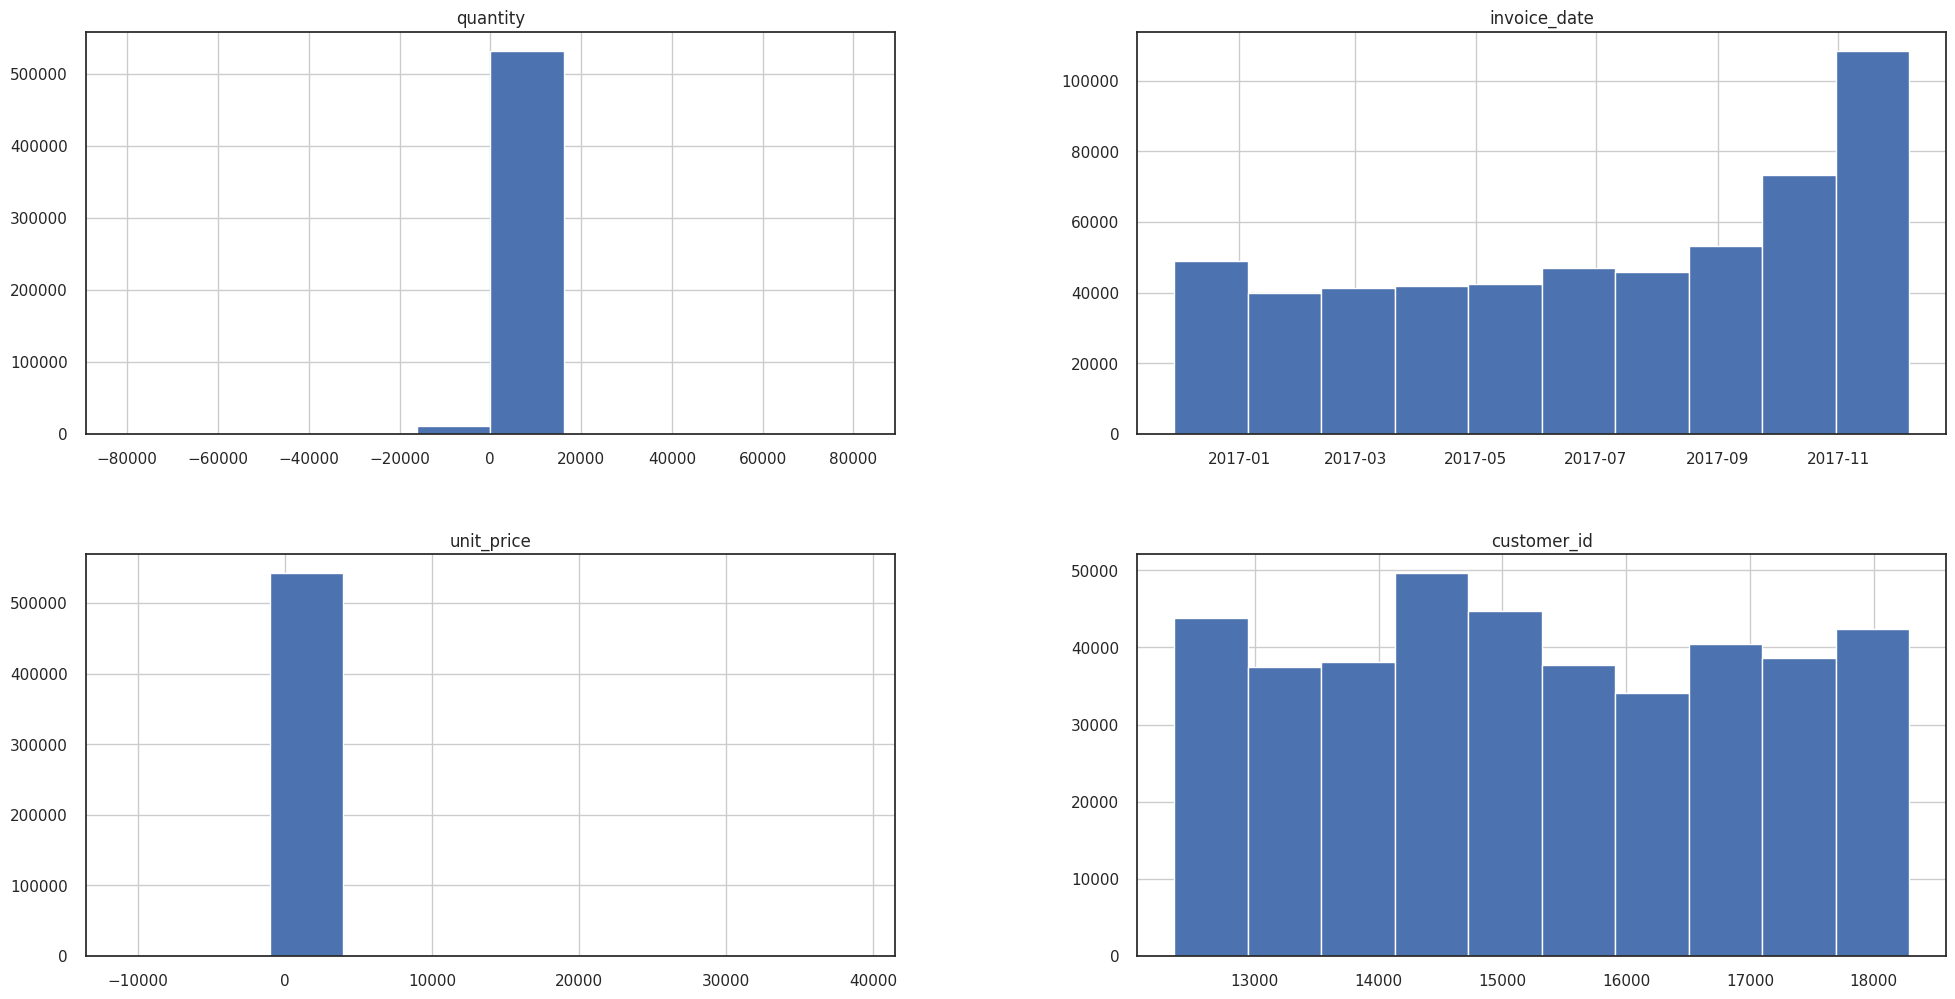

In [13]:
df2.hist();

In [14]:
starts.statistics_info(df2)

Non-Null      range       min   quant25    median   quant75      max          mean          std        skew       kurtosis
quantity       541909  161990.00 -80995.00      1.00      3.00     10.00  80995.0      9.552250   218.081158   -0.264076  119769.160031
unit_price     541909   50032.06 -11062.06      1.25      2.08      4.13  38970.0      4.611114    96.759853  186.506972   59005.719097
customer_id    406829    5941.00  12346.00  13953.00  15152.00  16791.00  18287.0  15287.690570  1713.600303    0.029835      -1.179982

There are some numbers that call attention. In unit_price and quantity are negative numbers.

### <font color='darkorange'>2.2.2. Categorical

In [15]:
print('Number of uniques: ')
for col in df2.select_dtypes(include='object'):
    print(f'{col}: {df2[col].nunique()}')

Number of uniques: 
invoice_no: 25900
stock_code: 4070
description: 4223
country: 38


The difference between stock_code numbers and descriptions draws attention.

## <font color='darkorange'>2.2. Univariate Analysis

### <font color='darkorange'>2.2.1. Invoice_no

In [16]:
returned_invoices = df2.invoice_no.str.contains(pat='[a-zA-Z]', regex=True)
df2.query('@returned_invoices').head()

invoice_no stock_code                       description  quantity invoice_date  unit_price  customer_id         country
141    C536379          D                          Discount        -1   2016-11-29       27.50      14527.0  United Kingdom
154    C536383     35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   2016-11-29        4.65      15311.0  United Kingdom
235    C536391      22556    PLASTERS IN TIN CIRCUS PARADE        -12   2016-11-29        1.65      17548.0  United Kingdom
236    C536391      21984  PACK OF 12 PINK PAISLEY TISSUES        -24   2016-11-29        0.29      17548.0  United Kingdom
237    C536391      21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   2016-11-29        0.29      17548.0  United Kingdom

Invoices with letters means it is a return transaction as indicated by the negative values ​​in the column quantity.

In [17]:
# Check Invoices numbers without C
invoice_without_c = df2.invoice_no.isin(df2[returned_invoices].invoice_no.str[1:])
df2.query('@invoice_without_c')

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, country]
Index: []

There are no invoices with the same number of canceled invoices

In [18]:
returned_customers = df2[returned_invoices]
aux = df2[~returned_invoices]
returned_customers[~returned_customers.customer_id.isin(aux.customer_id)].customer_id.unique()[:10]

array([17547., 13958., 16995., 14213., 14679., 16138., 12870., 16252.,
       16579., 17307.])

In [19]:
df2.query('customer_id == 17547.0')

invoice_no stock_code           description  quantity invoice_date  unit_price  customer_id         country
4306    C536760      22175     PINK OWL SOFT TOY        -1   2016-11-30        2.95      17547.0  United Kingdom
4307    C536760      22273  FELTCRAFT DOLL MOLLY        -3   2016-11-30        2.95      17547.0  United Kingdom

And there are some customers with only canceled invoices, which means that canceled invoices are unique and not connected to other invoices.


With this information, I decided to divide the canceled invoices from the other invoices.


### <font color='darkorange'>2.2.2. Stock_Code

In [20]:
df2.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   2016-11-29        2.55      17850.0  United Kingdom
1     536365      71053                  WHITE METAL LANTERN         6   2016-11-29        3.39      17850.0  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   2016-11-29        2.75      17850.0  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   2016-11-29        3.39      17850.0  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   2016-11-29        3.39      17850.0  United Kingdom

Since most of the stock code starts with numbers, I will check if there is a stock code with only letters

In [21]:
df2[df2.stock_code.str.contains(pat='^[a-zA-Z]+$', regex=True)].stock_code.unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [22]:
stock_code = ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2.query('stock_code == @stock_code').head()

invoice_no stock_code     description  quantity invoice_date  unit_price  customer_id         country
45       536370       POST         POSTAGE         3   2016-11-29       18.00      12583.0          France
141     C536379          D        Discount        -1   2016-11-29       27.50      14527.0  United Kingdom
386      536403       POST         POSTAGE         1   2016-11-29       15.00      12791.0     Netherlands
1123     536527       POST         POSTAGE         1   2016-11-29       18.00      12662.0         Germany
1814     536544        DOT  DOTCOM POSTAGE         1   2016-11-29      569.77          NaN  United Kingdom

As there is no information about these specific transitions, these invoices will be discarded in the next step.

### <font color='darkorange'>2.2.3. quantity	

In [23]:
df2_clean = df2[~returned_invoices]
df2_clean = df2_clean.query('stock_code not in @stock_code')
df2_clean.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   2016-11-29        2.55      17850.0  United Kingdom
1     536365      71053                  WHITE METAL LANTERN         6   2016-11-29        3.39      17850.0  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   2016-11-29        2.75      17850.0  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   2016-11-29        3.39      17850.0  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   2016-11-29        3.39      17850.0  United Kingdom

In [24]:
starts.statistics_info(df2_clean)

Non-Null    range      min   quant25    median   quant75      max          mean          std        skew       kurtosis
quantity       530419  90595.0  -9600.0      1.00      3.00     10.00  80995.0     10.253177   159.868538  433.651234  211815.514184
unit_price     530419    649.5      0.0      1.25      2.08      4.13    649.5      3.263716     4.444391   24.866056    2210.717112
customer_id    396515   5941.0  12346.0  13975.00  15159.00  16801.00  18287.0  15301.349964  1709.783608    0.024004      -1.178771

In [25]:
df2_clean.query('quantity <= 0').sort_values('quantity')

invoice_no stock_code                   description  quantity invoice_date  unit_price  customer_id         country
225530     556691      23005  printing smudges/thrown away     -9600   2017-06-12         0.0          NaN  United Kingdom
225529     556690      23005  printing smudges/thrown away     -9600   2017-06-12         0.0          NaN  United Kingdom
225528     556687      23003  Printing smudges/thrown away     -9058   2017-06-12         0.0          NaN  United Kingdom
115818     546152     72140F                    throw away     -5368   2017-03-07         0.0          NaN  United Kingdom
431381     573596     79323W        Unsaleable, destroyed.     -4830   2017-10-29         0.0          NaN  United Kingdom
...           ...        ...                           ...       ...          ...         ...          ...             ...
75242      542566     84964B                           NaN        -1   2017-01-26         0.0          NaN  United Kingdom
156618     550153     85167B                       DAMAGED        -1   2017-04-12         0.0          NaN  United Kingdom
74284      542415     84967B                           NaN        -1   2017-01-25         0.0          NaN  United Kingdom
51763      540679      21667                           NaN        -1   2017-01-08         0.0          NaN  United Kingdom
75229      542553      21805                           NaN        -1   2017-01-26         0.0          NaN  United Kingdom

[1336 rows x 8 columns]

After checking the negative quantities, I discovered that they represent notes to write off products.

In [26]:
df2_clean = df2_clean.query('quantity > 0')

### <font color='darkorange'>2.2.4. Invoice_date

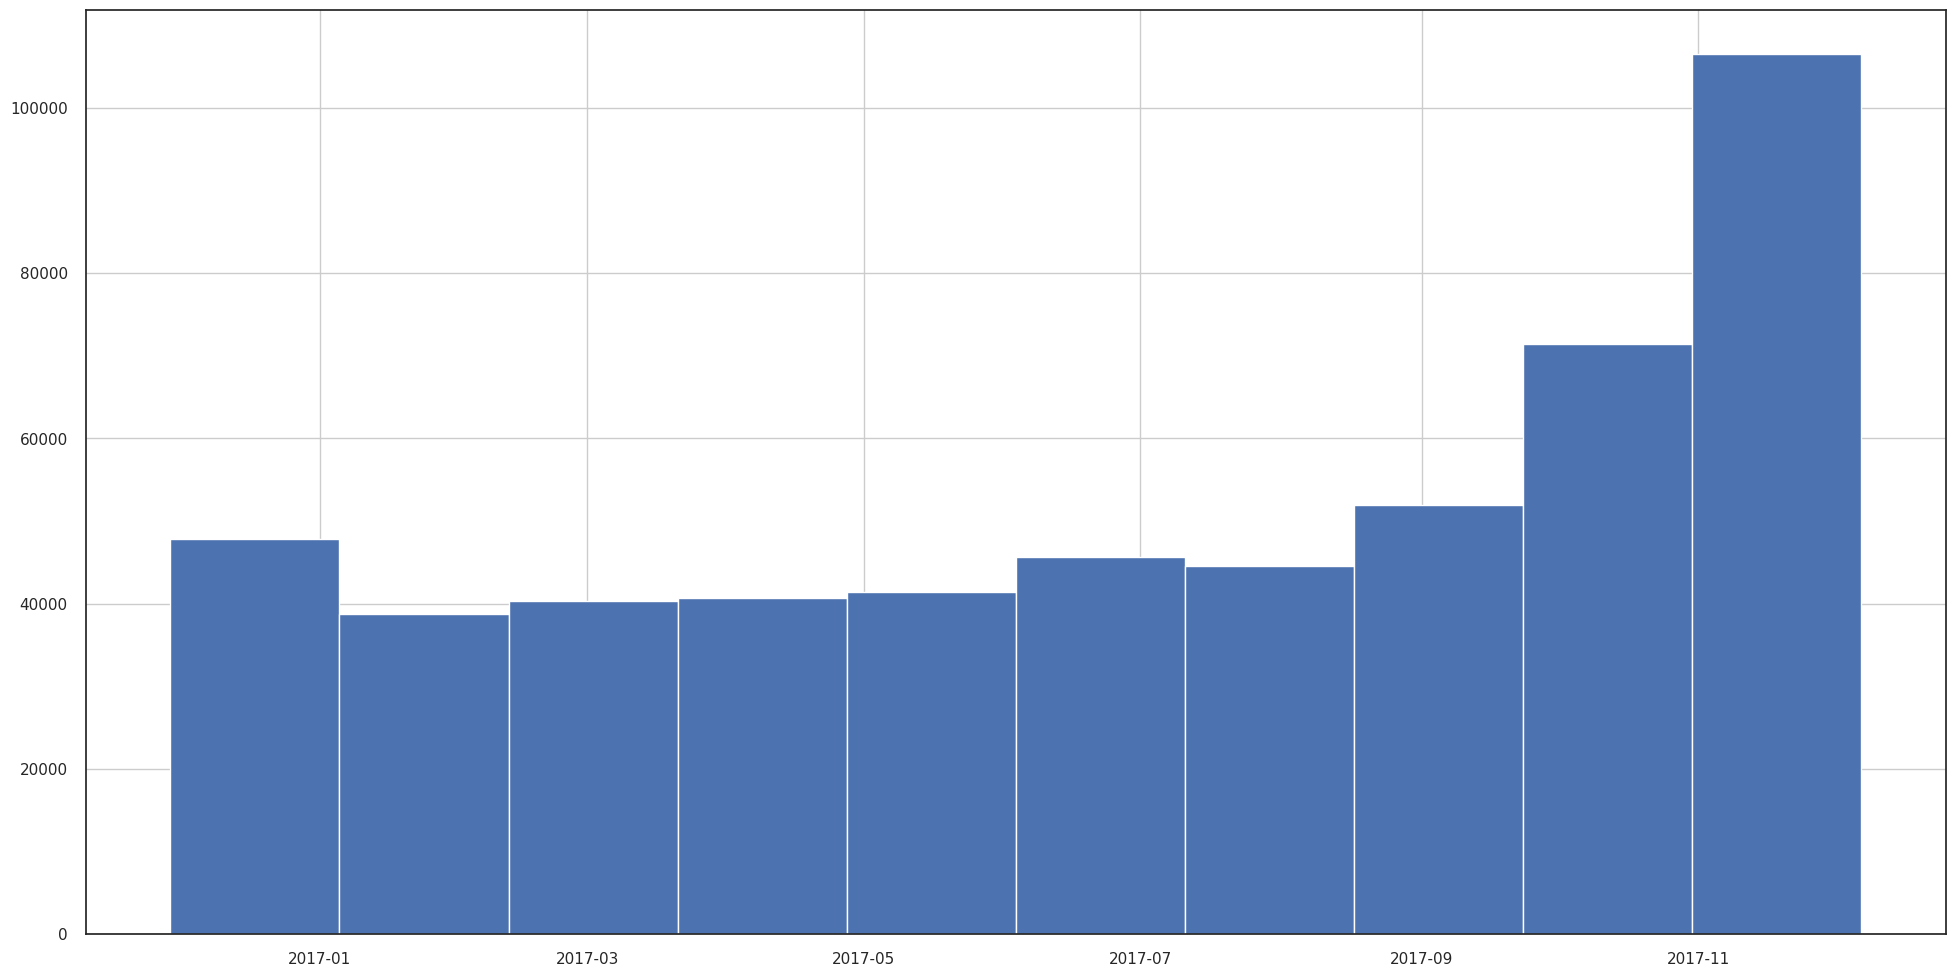

In [27]:
df2_clean.invoice_date.hist();

In [28]:
print(f'First day: {df2_clean.invoice_date.min()}')
print(f'Last day:  {df2_clean.invoice_date.max()}')

First day: 2016-11-29 00:00:00
Last day:  2017-12-07 00:00:00


### <font color='darkorange'>2.2.5. Unit_price

In [29]:
starts.statistics_info(df2_clean)

Non-Null    range      min   quant25    median   quant75      max          mean          std        skew       kurtosis
quantity       529083  80994.0      1.0      1.00      3.00     11.00  80995.0     10.670229   157.099233  459.672135  227638.300347
unit_price     529083    649.5      0.0      1.25      2.08      4.13    649.5      3.271957     4.446968   24.880972    2210.982127
customer_id    396515   5941.0  12346.0  13975.00  15159.00  16801.00  18287.0  15301.349964  1709.783608    0.024004      -1.178771

In [30]:
# Check unitprice = 0
df2_clean.query('unit_price == 0').head()

invoice_no stock_code description  quantity invoice_date  unit_price  customer_id         country
622      536414      22139         NaN        56   2016-11-29         0.0          NaN  United Kingdom
1970     536545      21134         NaN         1   2016-11-29         0.0          NaN  United Kingdom
1971     536546      22145         NaN         1   2016-11-29         0.0          NaN  United Kingdom
1972     536547      37509         NaN         1   2016-11-29         0.0          NaN  United Kingdom
1987     536549     85226A         NaN         1   2016-11-29         0.0          NaN  United Kingdom

The invoices with 0 unit price don't have usefull information

After checking the descriptions with missing values, I discovered that the purchases do not contain any useful information.

In [31]:
df2_clean = df2_clean.query('unit_price > 0.01')

### <font color='darkorange'>2.2.6. Description

In [32]:
starts.type_na(df2_clean)

Type  number na percent na
invoice_no            object          0      0.0 %
stock_code            object          0      0.0 %
description           object          0      0.0 %
quantity               int64          0      0.0 %
invoice_date  datetime64[ns]          0      0.0 %
unit_price           float64          0      0.0 %
customer_id          float64     131436     24.9 %
country               object          0      0.0 %

In [33]:
df2_clean.description = df2_clean.description.str.strip().str.upper()

In [34]:
# Check stock code and descriptions
print( f'stock_code: {df2_clean.stock_code.nunique()}')
print( f'description: {df2_clean.description.nunique()}')

stock_code: 3912
description: 4006


After performing all the necessary cleaning, the difference between these columns still remains in the dataset.

In [35]:
# check stock code with more than one description
aux = df2_clean.groupby('stock_code')[['description']].nunique().reset_index().sort_values('description', ascending=False)
aux[aux.description > 1]

stock_code  description
2049      23196            4
2089      23236            4
2228      23396            3
104      17107D            3
2364      23535            3
...         ...          ...
3550     90014C            2
2002      23148            2
46       16156L            2
123       20622            2
175       20725            2

[217 rows x 2 columns]

In [36]:
df2_clean.query('stock_code == "23396"').description.unique()

array(['BUTTERFLY CUSHION COVER', 'LA JARDIN BOTANIQUE CUSHION COVER',
       'LE JARDIN BOTANIQUE CUSHION COVER'], dtype=object)

After checking the stock codes that had more than one description, I found that the additional descriptions were only minor corrections to the name.

### <font color='darkorange'>2.2.7. customer_id	

In [37]:
starts.type_na(df2_clean)

Type  number na percent na
invoice_no            object          0      0.0 %
stock_code            object          0      0.0 %
description           object          0      0.0 %
quantity               int64          0      0.0 %
invoice_date  datetime64[ns]          0      0.0 %
unit_price           float64          0      0.0 %
customer_id          float64     131436     24.9 %
country               object          0      0.0 %

In [38]:
# check na customers
df2_clean[df2_clean.customer_id.isna()]

invoice_no stock_code                      description  quantity invoice_date  unit_price  customer_id         country
1443       536544      21773  DECORATIVE ROSE BATHROOM BOTTLE         1   2016-11-29        2.51          NaN  United Kingdom
1444       536544      21774  DECORATIVE CATS BATHROOM BOTTLE         2   2016-11-29        2.51          NaN  United Kingdom
1445       536544      21786                POLKADOT RAIN HAT         4   2016-11-29        0.85          NaN  United Kingdom
1446       536544      21787            RAIN PONCHO RETROSPOT         2   2016-11-29        1.66          NaN  United Kingdom
1447       536544      21790               VINTAGE SNAP CARDS         9   2016-11-29        1.66          NaN  United Kingdom
...           ...        ...                              ...       ...          ...         ...          ...             ...
541535     581498     85049e        SCANDINAVIAN REDS RIBBONS         4   2017-12-07        3.29          NaN  United Kingdom
541536     581498     85099B          JUMBO BAG RED RETROSPOT         5   2017-12-07        4.13          NaN  United Kingdom
541537     581498     85099C   JUMBO  BAG BAROQUE BLACK WHITE         4   2017-12-07        4.13          NaN  United Kingdom
541538     581498      85150    LADIES & GENTLEMEN METAL SIGN         1   2017-12-07        4.96          NaN  United Kingdom
541539     581498      85174                S/4 CACTI CANDLES         1   2017-12-07       10.79          NaN  United Kingdom

[131436 rows x 8 columns]

In [39]:
invoice_na = df2_clean[df2_clean.customer_id.isna()].invoice_no
print(f'Invoices withou Customers ID: {invoice_na.nunique()}')

Invoices withou Customers ID: 1371


#### <font color='darkorange'>2.2.7.1. customer_id complete na

To retain this data and aid with clustering, invoices with no customer information were assigned a false ID. As a result, each invoice with missing customer information was given a new ID.

In [40]:
df2_clean.customer_id.max()

18287.0

New ID - 20000, 20001 ...

In [41]:
# Create New Id's
df_new_id = pd.DataFrame(invoice_na.drop_duplicates())
df_new_id['customer_id'] = np.arange(20000, 20000 + len(df_new_id), 1)

# Merge original with new id'set
df2_clean = df2_clean.merge(df_new_id, on='invoice_no', how='left')

# Combine
df2_clean['customer_id'] = df2_clean.customer_id_x.combine_first( df2_clean.customer_id_y )

# Drop Extra Columns
df2_clean = df2_clean.drop( columns=['customer_id_x', 'customer_id_y'])

In [42]:
starts.type_na(df2_clean)

Type  number na percent na
invoice_no            object          0      0.0 %
stock_code            object          0      0.0 %
description           object          0      0.0 %
quantity               int64          0      0.0 %
invoice_date  datetime64[ns]          0      0.0 %
unit_price           float64          0      0.0 %
country               object          0      0.0 %
customer_id          float64          0      0.0 %

### <font color='darkorange'>2.2.8. country

In [43]:
df2_clean.drop_duplicates(subset = 'invoice_no').country.value_counts(normalize=True)

United Kingdom          0.905241
Germany                 0.022388
France                  0.019356
EIRE                    0.014353
Belgium                 0.004953
Netherlands             0.004700
Spain                   0.004447
Australia               0.002830
Switzerland             0.002527
Portugal                0.002527
Finland                 0.002022
Italy                   0.001769
Sweden                  0.001718
Norway                  0.001617
Channel Islands         0.001263
Poland                  0.000960
Japan                   0.000960
Denmark                 0.000910
Austria                 0.000859
Cyprus                  0.000708
Unspecified             0.000657
Israel                  0.000404
Hong Kong               0.000354
Iceland                 0.000354
Canada                  0.000253
Malta                   0.000253
Greece                  0.000253
USA                     0.000253
Lithuania               0.000202
Singapore               0.000202
European C

In [44]:
df2_clean.drop_duplicates(subset = 'invoice_no').query('country == "Unspecified"')

invoice_no stock_code                          description  quantity invoice_date  unit_price      country  customer_id
148304     549687      20685                DOORMAT RED RETROSPOT         2   2017-04-09        7.95  Unspecified      12363.0
179260     552695      22953   BIRTHDAY PARTY CORDON BARRIER TAPE        24   2017-05-08        1.25  Unspecified      16320.0
190986     553857      23090         VINTAGE GLASS T-LIGHT HOLDER        12   2017-05-17        0.83  Unspecified      20669.0
227311     557499      23122               PARTY CHARMS 50 PIECES        12   2017-06-18        0.83  Unspecified      16320.0
249847     559521      21634        ASSORTED MINI MADRAS NOTEBOOK        24   2017-07-06        0.39  Unspecified      20892.0
255524     559929      22960             JAM MAKING SET WITH JARS         6   2017-07-12        4.25  Unspecified      14265.0
274613     561658     47563A  RETRO LONGBOARD IRONING BOARD COVER         1   2017-07-26        1.25  Unspecified      12743.0
274702     561661      22844     VINTAGE CREAM DOG FOOD CONTAINER         2   2017-07-26        8.50  Unspecified      12743.0
299615     563947      23236            STORAGE TIN VINTAGE DOILY        24   2017-08-20        2.89  Unspecified      12363.0
300105     564051      23355           HOT WATER BOTTLE KEEP CALM         4   2017-08-20        4.95  Unspecified      14265.0
314252     565303      22904            CALENDAR PAPER CUT DESIGN         1   2017-08-31        2.95  Unspecified      21046.0
458957     576646      22326   ROUND SNACK BOXES SET OF4 WOODLAND         6   2017-11-14        2.95  Unspecified      21274.0
485490     578539      22150             3 STRIPEY MICE FELTCRAFT         6   2017-11-22        1.95  Unspecified      21300.0

In [45]:
df2_clean.drop_duplicates(subset = 'invoice_no').query('country == "European Community"')

invoice_no stock_code                      description  quantity invoice_date  unit_price             country  customer_id
163343     551013      22839  3 TIER CAKE TIN GREEN AND CREAM         1   2017-04-24       14.95  European Community      15108.0
207337     555542      21675             BUTTERFLIES STICKERS        12   2017-06-03        0.85  European Community      15108.0
265390     560783      22446        PIN CUSHION BABUSHKA PINK         6   2017-07-19        3.35  European Community      15108.0

# <font color='darkorange'>3.0. Data Cleaning

In [46]:
df3 = df1.copy()

In [47]:
# # Replace Customer ID NA
# # Invoice without customers
# invoice_na = df3[df3.customer_id.isna()].invoice_no

# # Create New Id's
# df_new_id = pd.DataFrame(invoice_na.drop_duplicates())
# df_new_id['customer_id'] = np.arange(-1, (-1 - len(df_new_id)), -1)

# # Merge original with new id'set
# df3 = df3.merge(df_new_id, on='invoice_no', how='left')

# # Combine
# df3['customer_id'] = df3.customer_id_x.combine_first( df3.customer_id_y )

# # Drop Extra Columns
# df3 = df3.drop( columns=['customer_id_x', 'customer_id_y'])

In [48]:
# Stock_code
stock_code = ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df3 = df3.query('stock_code not in @stock_code')


# Unit_price
df3 = df3.query('unit_price > 0.01')

df3 = df3.dropna()

# <font color='darkorange'>4.0. Feature Engineering

In [49]:
df4 = df3.copy()

In [50]:
# Invoice No
returned_invoices = df4.invoice_no.str.contains(pat='[a-zA-Z]', regex=True)
canceled = df4.query('@returned_invoices').copy()
purchased = df4.query('~@returned_invoices').copy()

# Quantity
purchased = purchased.query('quantity > 0')

In [51]:
starts.statistics_info(purchased)

Non-Null     range       min   quant25    median   quant75      max          mean          std        skew       kurtosis
quantity       396481  80994.00      1.00      2.00      6.00     12.00  80995.0     13.008187   179.608765  409.439971  177716.052368
unit_price     396481    649.46      0.04      1.25      1.95      3.75    649.5      2.884414     4.354880   34.042346    3209.024789
customer_id    396481   5941.00  12346.00  13975.00  15159.00  16801.00  18287.0  15301.442039  1709.762467    0.023950      -1.178759

In [52]:
# Gross Revenue ( quantity * unit_price )
purchased['gross_revenue'] = purchased.quantity * purchased.unit_price
canceled['gross_revenue'] = canceled.quantity * canceled.unit_price

purchased.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country  gross_revenue
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   2016-11-29        2.55      17850.0  United Kingdom          15.30
1     536365      71053                  WHITE METAL LANTERN         6   2016-11-29        3.39      17850.0  United Kingdom          20.34
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   2016-11-29        2.75      17850.0  United Kingdom          22.00
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   2016-11-29        3.39      17850.0  United Kingdom          20.34
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   2016-11-29        3.39      17850.0  United Kingdom          20.34

## <font color='darkorange'>4.2.Creating Customers Dataset

### <font color='darkorange'>Customer ID

In [53]:
# All customers
customers = pd.concat([purchased.customer_id, canceled.customer_id]).unique()
customers_ref = pd.DataFrame({'customer_id': customers})

### <font color='darkorange'>Total Purchase

In [54]:
total_purchase = (purchased.groupby('customer_id')[['gross_revenue']].sum()
                                                                     .reset_index()
                                                                     .rename(columns={'gross_revenue':'total_purchases'}))
customers_ref = customers_ref.merge(total_purchase, how='left', on='customer_id')

### <font color='darkorange'>Number of products

In [55]:
number_prod = (purchased.groupby('customer_id')[['stock_code']].count().reset_index()
                                                               .rename(columns = {'stock_code':'number_products'}))
customers_ref = customers_ref.merge(number_prod, how='left', on='customer_id')

### <font color='darkorange'>Number of unique produts

In [56]:
unique_prod = (purchased.groupby('customer_id')[['stock_code']].nunique().reset_index()
                                                               .rename(columns = {'stock_code':'nunique_products'}))
customers_ref = customers_ref.merge(unique_prod, how='left', on='customer_id')

### <font color='darkorange'>Average Basket Size

In [57]:
basket_size = df4.groupby(['customer_id', 'invoice_no'])[['quantity']].sum().reset_index()
avg_basket_size = basket_size.groupby('customer_id')[['quantity']].mean().reset_index().rename(columns = {'quantity':'avg_basket_size'})

customers_ref = customers_ref.merge(avg_basket_size, how='left', on='customer_id')

### <font color='darkorange'>Lifetime and Recency

In [58]:
today = df4.invoice_date.max()
time = purchased.groupby('customer_id')[['invoice_date']].agg({'invoice_date':['min', 'max']}).reset_index()
time.columns = ['customer_id', 'lifetime', 'recency']
time.lifetime = (today - time.lifetime).dt.days
time.recency = (today - time.recency).dt.days

customers_ref = customers_ref.merge(time, how='left', on='customer_id')

### <font color='darkorange'>Purchase Count

In [59]:
purchase_count = df4.groupby('customer_id')[['invoice_no']].nunique().reset_index().rename(columns={'invoice_no': 'purchase_count'})

customers_ref = customers_ref.merge(purchase_count, how='left', on='customer_id')

### <font color='darkorange'>Charge Back Count and Gross Revenue Charge Back

In [60]:
charge_back = (canceled.groupby('customer_id').agg({'gross_revenue': lambda x: x.sum(),
                                                    'invoice_no': lambda x: x.nunique()})
                                               .reset_index()
                                               .rename(columns={'gross_revenue':'gross_revenue_charge_back',
                                                                'invoice_no':'charge_back_count'}))

customers_ref = customers_ref.merge(charge_back, how='left', on='customer_id')
customers_ref[['charge_back_count', 'gross_revenue_charge_back']] = customers_ref[['charge_back_count', 'gross_revenue_charge_back']].fillna(0)

### <font color='darkorange'>Average Unit Price

In [61]:
avg_unt_price = purchased.groupby('customer_id')[['unit_price']].mean().reset_index().rename(columns={'unit_price':'avg_unt_price'})
customers_ref = customers_ref.merge(avg_unt_price, how='left', on='customer_id')

### <font color='darkorange'>Return Rate

In [62]:
customers_ref['return_rate'] = customers_ref.charge_back_count / customers_ref.purchase_count

### <font color='darkorange'>Average Purchase Interval

In [63]:
customers_ref['avg_purchase_interval'] = customers_ref.apply(lambda x: ( x.lifetime / x.purchase_count ) if x.purchase_count > 1 
                                                                                                       else x.lifetime, axis=1)

### <font color='darkorange'>Frequency

In [64]:
customers_ref['frequency'] = customers_ref.apply(lambda x: ( x.purchase_count / x.lifetime ) if x.lifetime != 0 
                                                                                                       else 0, axis=1)

### <font color='darkorange'>Gross Revenue

In [65]:
customers_ref['gross_revenue'] = customers_ref.total_purchases + customers_ref.gross_revenue_charge_back

### <font color='darkorange'>Average Order Value

In [66]:
customers_ref['avg_order_value'] = customers_ref.gross_revenue / customers_ref.purchase_count

### <font color='darkorange'>Customers Profile

In [67]:
customers_ref = customers_ref.drop(columns=['total_purchases', 'gross_revenue_charge_back'])

In [68]:
customers_ref = customers_ref[['customer_id', 'lifetime', 'recency', 'avg_purchase_interval', 'frequency', 'number_products', 'nunique_products', 'avg_basket_size',
                              'purchase_count', 'charge_back_count', 'return_rate', 'avg_unt_price', 'avg_order_value', 'gross_revenue']]

In [69]:
customers_ref = customers_ref.query('gross_revenue > 1').reset_index(drop=True)

In [70]:
starts.statistics_info(customers_ref)

Non-Null          range           min       quant25        median       quant75         max          mean          std       skew     kurtosis
customer_id                4320    5940.000000  12347.000000  13815.750000  15299.500000  16778.250000   18287.000  15300.771065  1720.217887   0.001072    -1.194708
lifetime                   4320     373.000000      0.000000    113.000000    249.000000    326.000000     373.000    223.077083   117.756098  -0.369805    -1.227218
recency                    4320     373.000000      0.000000     17.000000     50.000000    142.000000     373.000     92.013657   100.069076   1.246781     0.432409
avg_purchase_interval      4320     373.000000      0.000000     31.000000     60.000000    119.000000     373.000     89.597846    84.740189   1.616246     2.018949
frequency                  4320       1.500000      0.000000      0.008403      0.016667      0.032258       1.500      0.029349     0.056480  12.055820   219.293354
number_products            4320    7837.000000      1.000000     17.000000     41.000000    100.000000    7838.000     91.728241   228.812826  18.091345   482.476750
nunique_products           4320    1785.000000      1.000000     16.000000     35.000000     77.250000    1786.000     61.584954    85.403084   6.916728    99.614722
avg_basket_size            4320    7823.750000      0.250000     80.000000    140.000000    236.158333    7824.000    200.084624   269.782651  10.017756   193.522024
purchase_count             4320     242.000000      1.000000      1.000000      3.000000      5.000000     243.000      5.031019     9.132325  11.431686   222.194005
charge_back_count          4320      45.000000      0.000000      0.000000      0.000000      1.000000      45.000      0.771991     1.973570   9.174288   151.425977
return_rate                4320       0.750000      0.000000      0.000000      0.000000      0.200000       0.750      0.099820     0.161314   1.473640     1.039043
avg_unt_price              4320     434.527500      0.122500      2.157368      2.829022      3.712069     434.650      3.463307     8.875852  36.542242  1578.464440
avg_order_value            4320    9903.908333      0.966667    154.895000    240.795357    372.115000    9904.875    326.335120   390.520513   8.846226   136.134306
gross_revenue              4320  278775.120000      2.900000    300.845000    654.760000   1611.432500  278778.020   1920.742988  8320.811940  21.507718   595.758154

# <font color='darkorange'>5.0. Exploratory Data Analysis - Customers

In [71]:
df5 = customers_ref.copy()
df5 = df5.dropna()

## <font color='darkorange'>5.1. Univariate Analysis

In [72]:
profile = ProfileReport( df5 )
profile.to_file( 'reports/customers_analysis_c03.html' ) 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Will be analyzed:

- Min, Max, Range
- Mean, Median
- Standard Deviation, Variance
- Coefficient of Variation
- Histogram

| **Features**          | **Variability** |
| ---                   | ---             |
| lifetime              | ok              |
| recency               | ok              |
| avg_purchase_interval | ok              |
| nunique_products      | high            |
| avg_basket_size       | high            |
| purchase_count        | high            |
| charge_back_count     | low             |
| return_rate           | low             |
| avg_unt_price         | low             |
| avg_order_value       | high            |
| gross_revenue         | high            |

## <font color='darkorange'>5.2. Bivariate Analysis

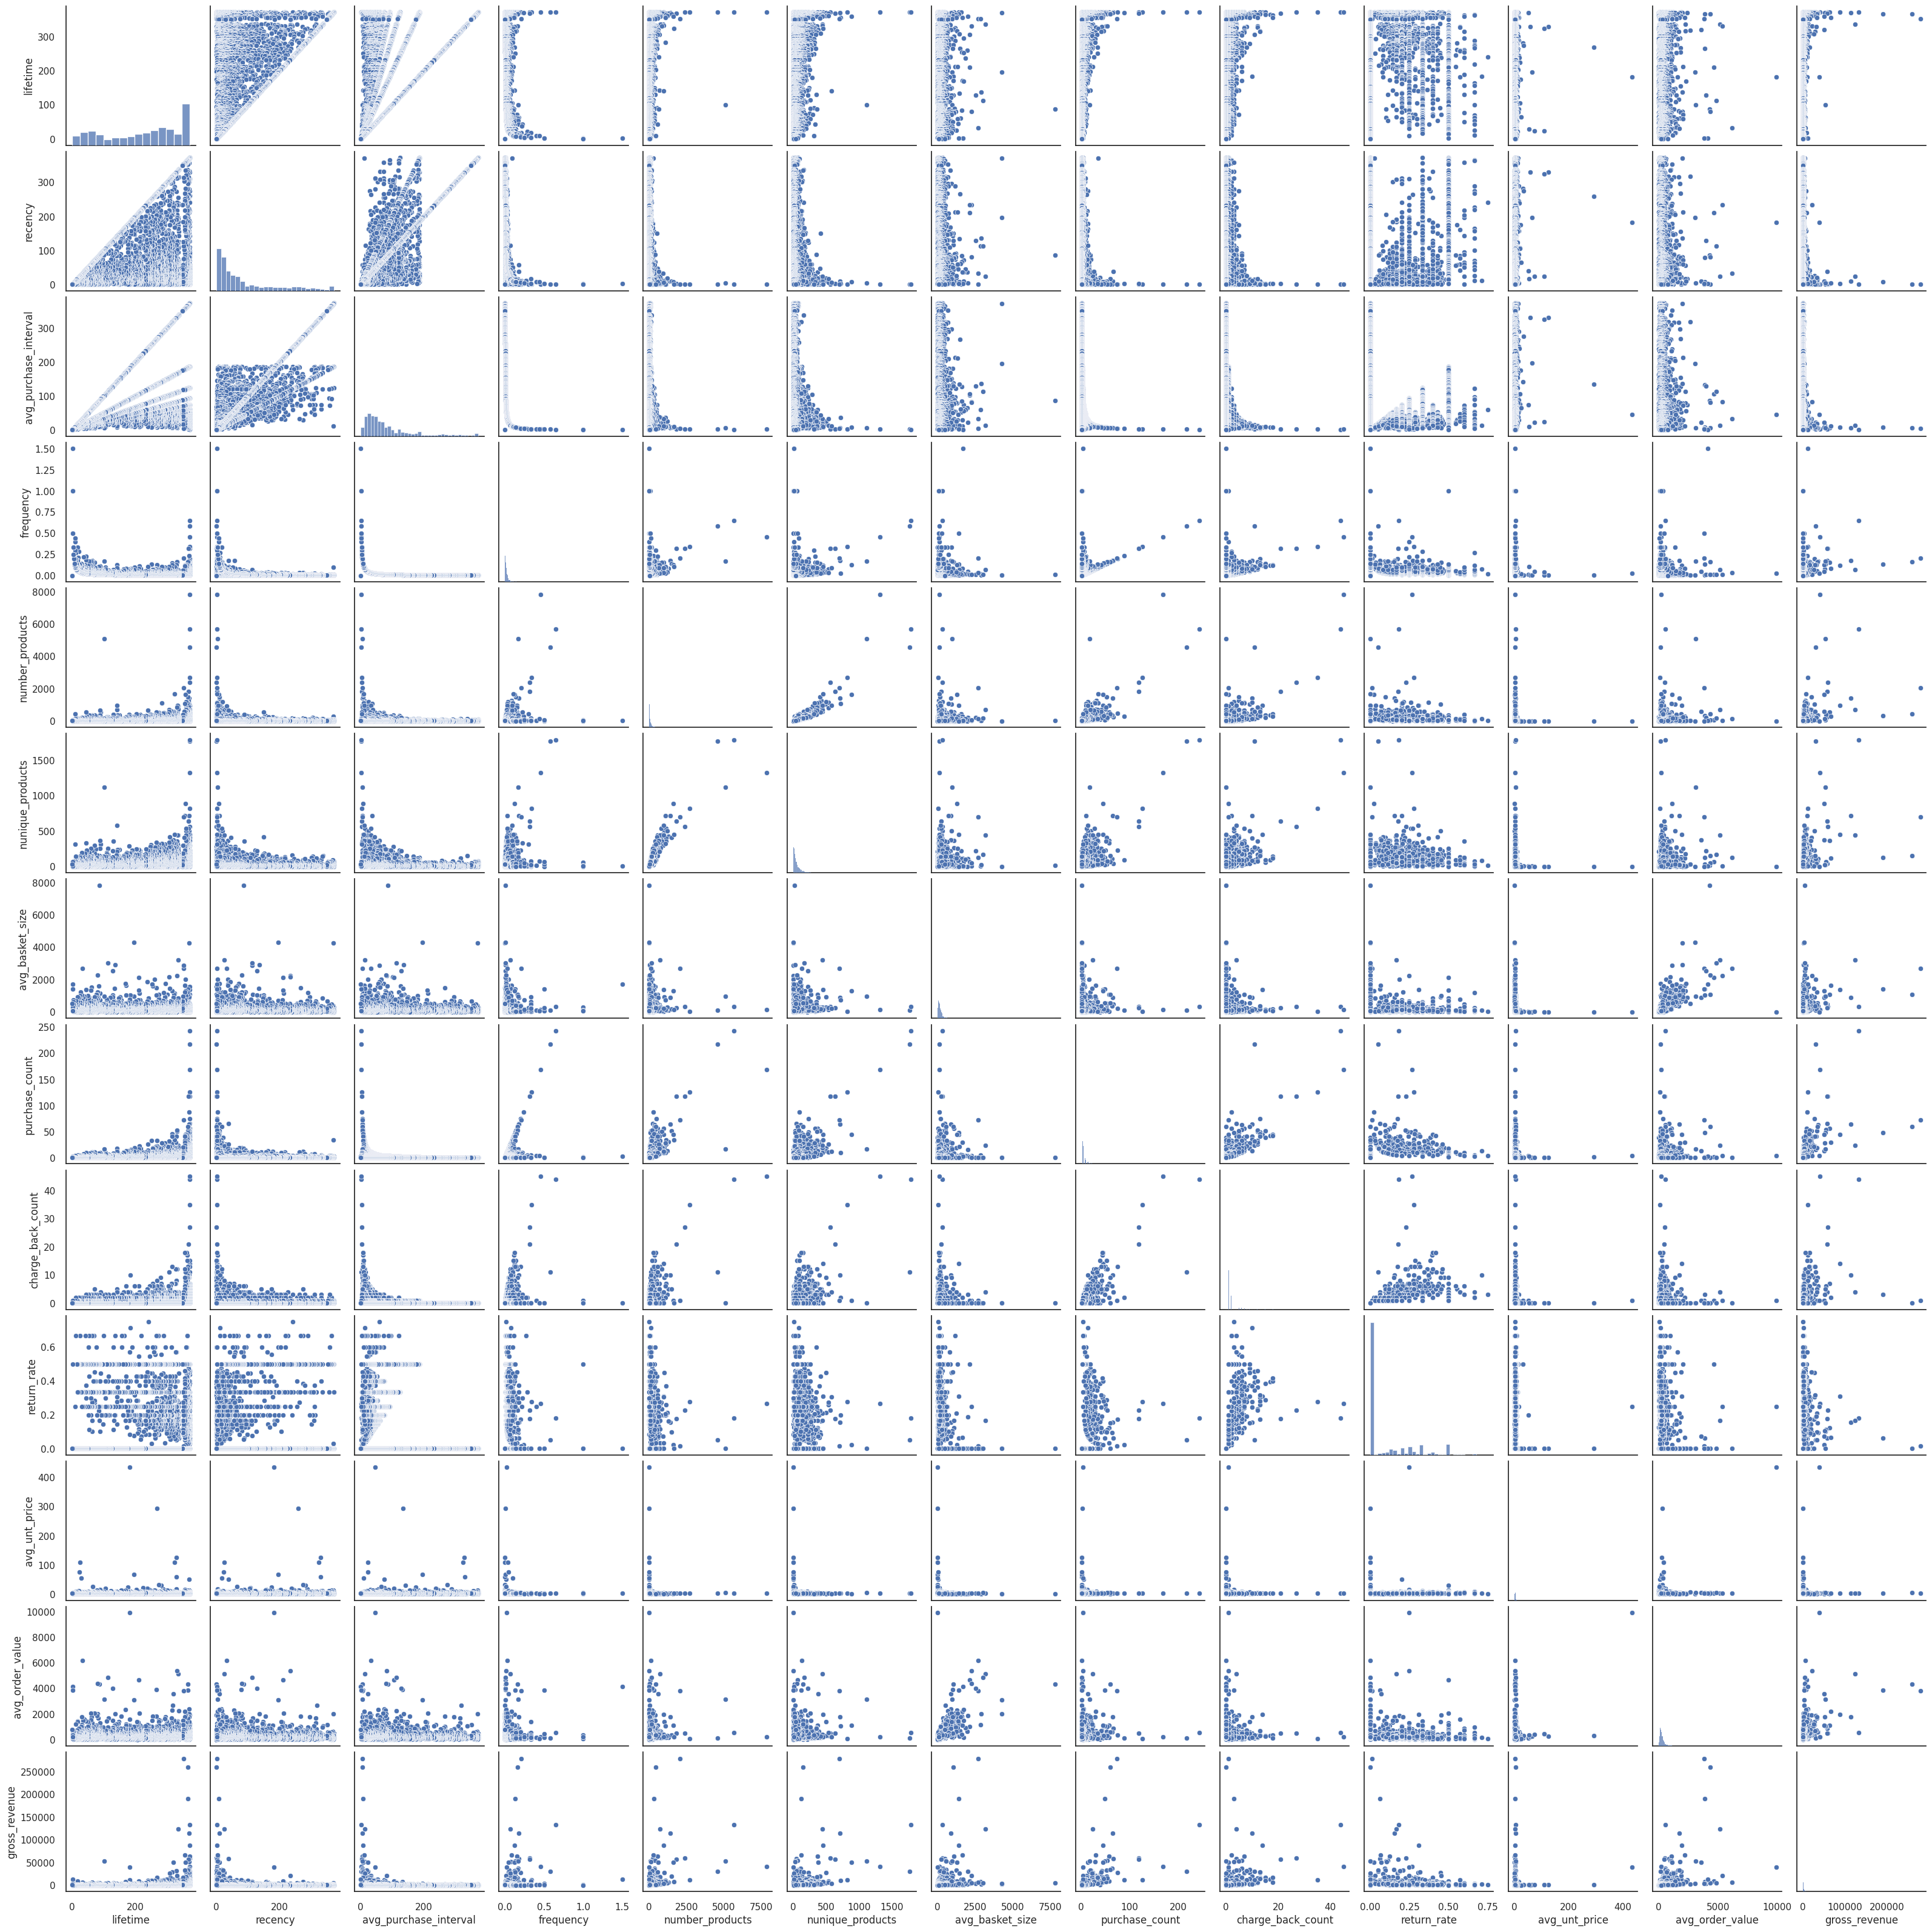

In [73]:
sns.pairplot(df5.drop(columns='customer_id'));

- avg_unit_price has low variance

# <font color='darkorange'>6.0. Pre Processing

In [74]:
df6 = df5.copy()
X = df6.drop(columns = 'customer_id')
cols = X.columns

In [75]:
# instancing minmax
minmax = MinMaxScaler()

# transforming data
X = pd.DataFrame(minmax.fit_transform(X), columns=cols)

In [76]:
starts.statistics_info(X)

Non-Null  range  min   quant25    median   quant75  max      mean       std       skew     kurtosis
lifetime                   4320    1.0  0.0  0.302949  0.667560  0.873995  1.0  0.598062  0.315700  -0.369805    -1.227218
recency                    4320    1.0  0.0  0.045576  0.134048  0.380697  1.0  0.246685  0.268282   1.246781     0.432409
avg_purchase_interval      4320    1.0  0.0  0.083110  0.160858  0.319035  1.0  0.240209  0.227185   1.616246     2.018949
frequency                  4320    1.0  0.0  0.005602  0.011111  0.021505  1.0  0.019566  0.037653  12.055820   219.293354
number_products            4320    1.0  0.0  0.002042  0.005104  0.012632  1.0  0.011577  0.029196  18.091345   482.476750
nunique_products           4320    1.0  0.0  0.008403  0.019048  0.042717  1.0  0.033941  0.047845   6.916728    99.614722
avg_basket_size            4320    1.0  0.0  0.010193  0.017862  0.030153  1.0  0.025542  0.034483  10.017756   193.522024
purchase_count             4320    1.0  0.0  0.000000  0.008264  0.016529  1.0  0.016657  0.037737  11.431686   222.194005
charge_back_count          4320    1.0  0.0  0.000000  0.000000  0.022222  1.0  0.017155  0.043857   9.174288   151.425977
return_rate                4320    1.0  0.0  0.000000  0.000000  0.266667  1.0  0.133094  0.215086   1.473640     1.039043
avg_unt_price              4320    1.0  0.0  0.004683  0.006229  0.008261  1.0  0.007688  0.020426  36.542242  1578.464440
avg_order_value            4320    1.0  0.0  0.015542  0.024216  0.037475  1.0  0.032853  0.039431   8.846226   136.134306
gross_revenue              4320    1.0  0.0  0.001069  0.002338  0.005770  1.0  0.006880  0.029848  21.507718   595.758154

# <font color='darkorange'>7.0. Embedding Space ( Latenting Space )

In [77]:
cols_selected = ['recency', 'frequency', 'number_products', 'nunique_products', 'return_rate', 
                  'avg_order_value', 'avg_basket_size', 'lifetime']
all_cols = X.columns

## <font color='darkorange'>PCA</font>

Principal Component Analysis (PCA) is a dimensionality reduction technique used to find a set of features, known as principal components, that capture the most variability in the data.

The main idea behind PCA is to transform a set of correlated variables into a new set of uncorrelated variables, the principal components. These components are obtained through linear combinations of the original variables in such a way that the first principal component captures the highest possible variance, the second component captures the second highest variance, and so on.



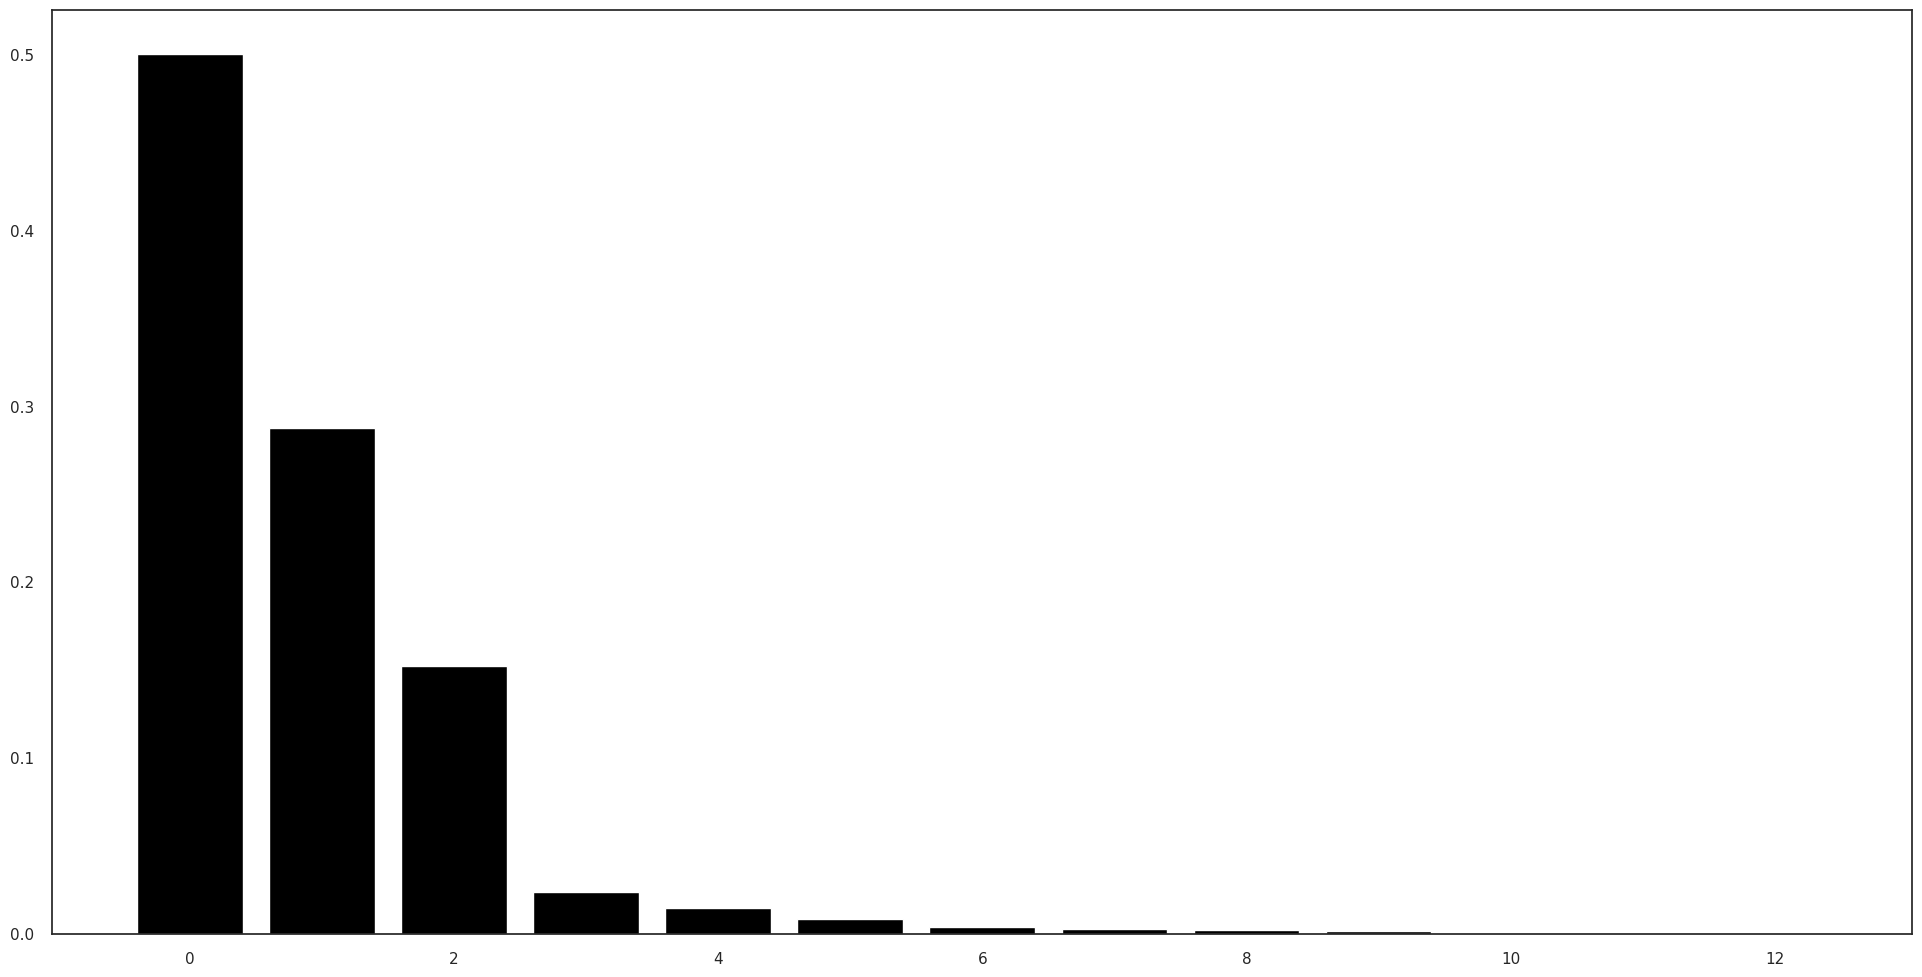

In [78]:
# Instancing
pca = PCA( n_components=X[all_cols].shape[1] )

# Training
principal_components = pca.fit_transform( X[all_cols] )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

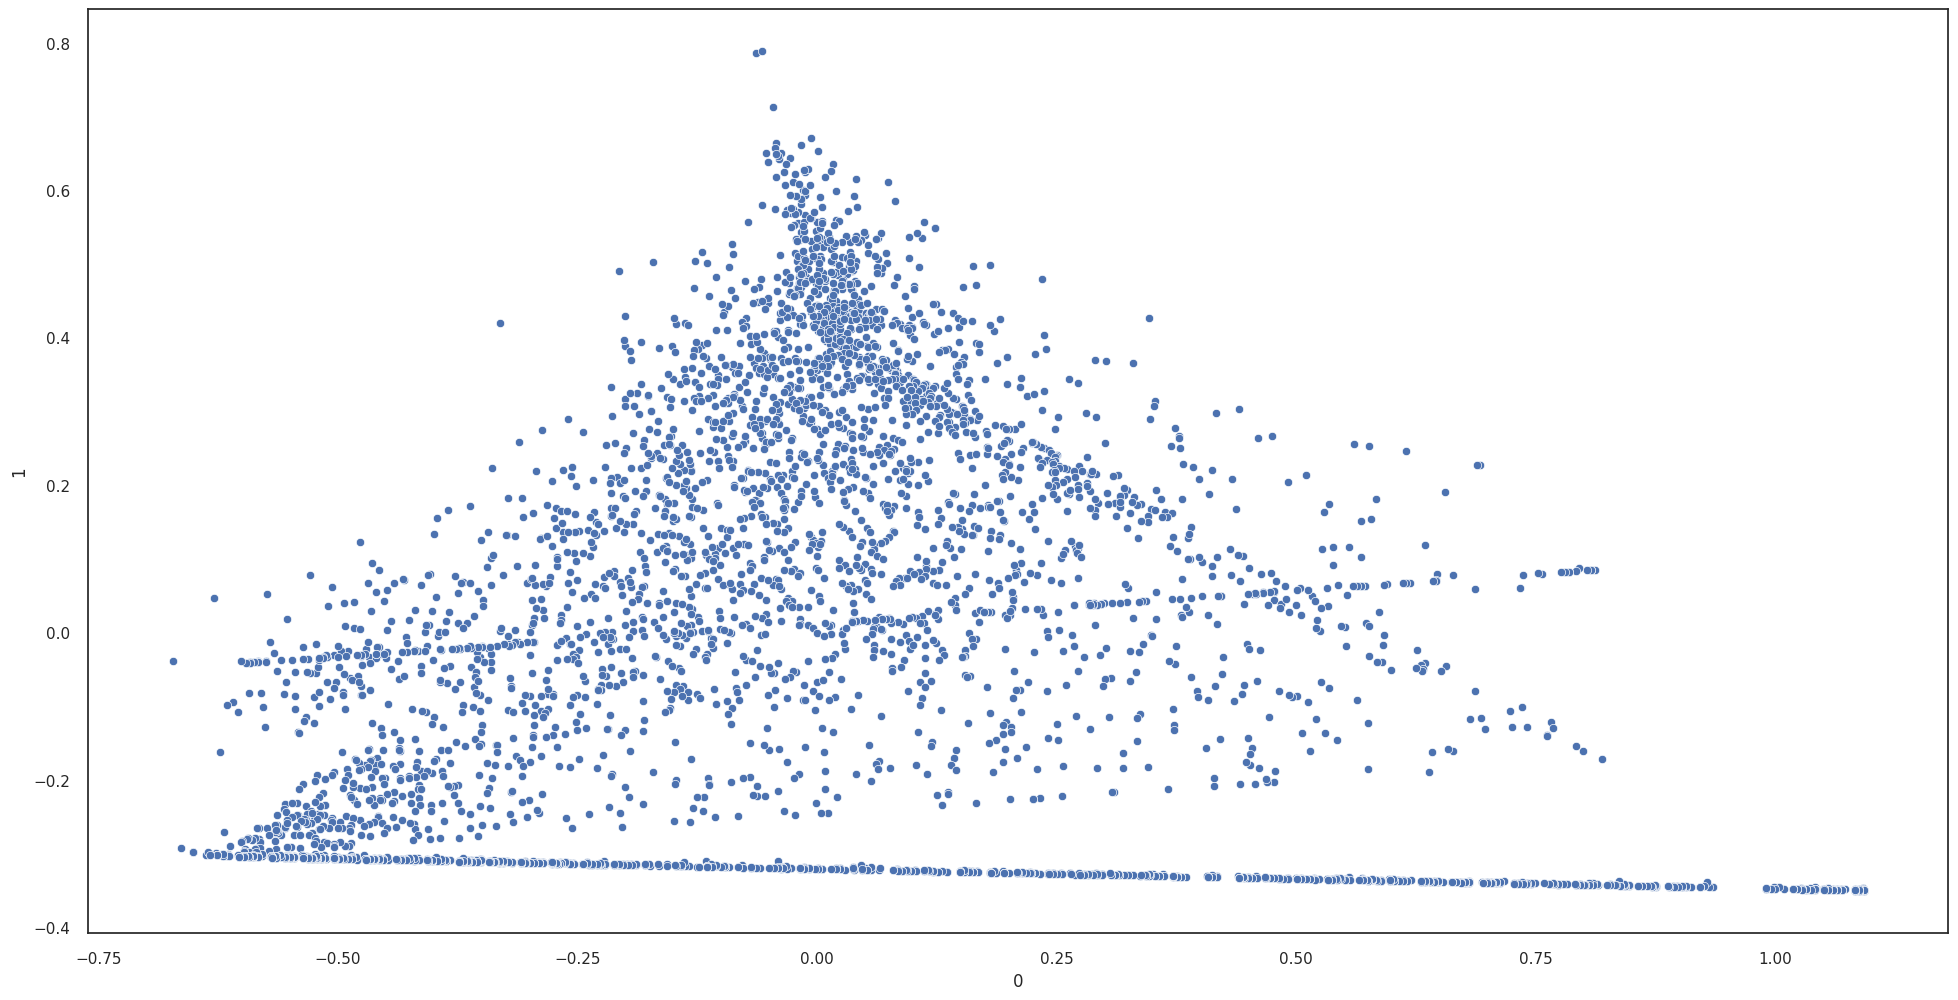

In [79]:
sns.scatterplot( x=0, y=1, data=df_pca );

## <font color='darkorange'>t-SNE</font>

T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction algorithm used to visualize and explore high-dimensional data. Unlike the PCA, which seeks to preserve the global variance of the data, the T-SNE aims to preserve the proximity relationships between the original points during the projection in a smaller space.


T-SNE works by mapping high-dimensional points onto a low-dimensional space such that similar points are close to each other, while dissimilar points are far apart. It accomplishes this by calculating the similarity probabilities between the high-dimensional points and the corresponding probabilities in the low-dimensional space. It then optimizes the arrangement of points in low-dimensional space to minimize the divergence between these probabilities.

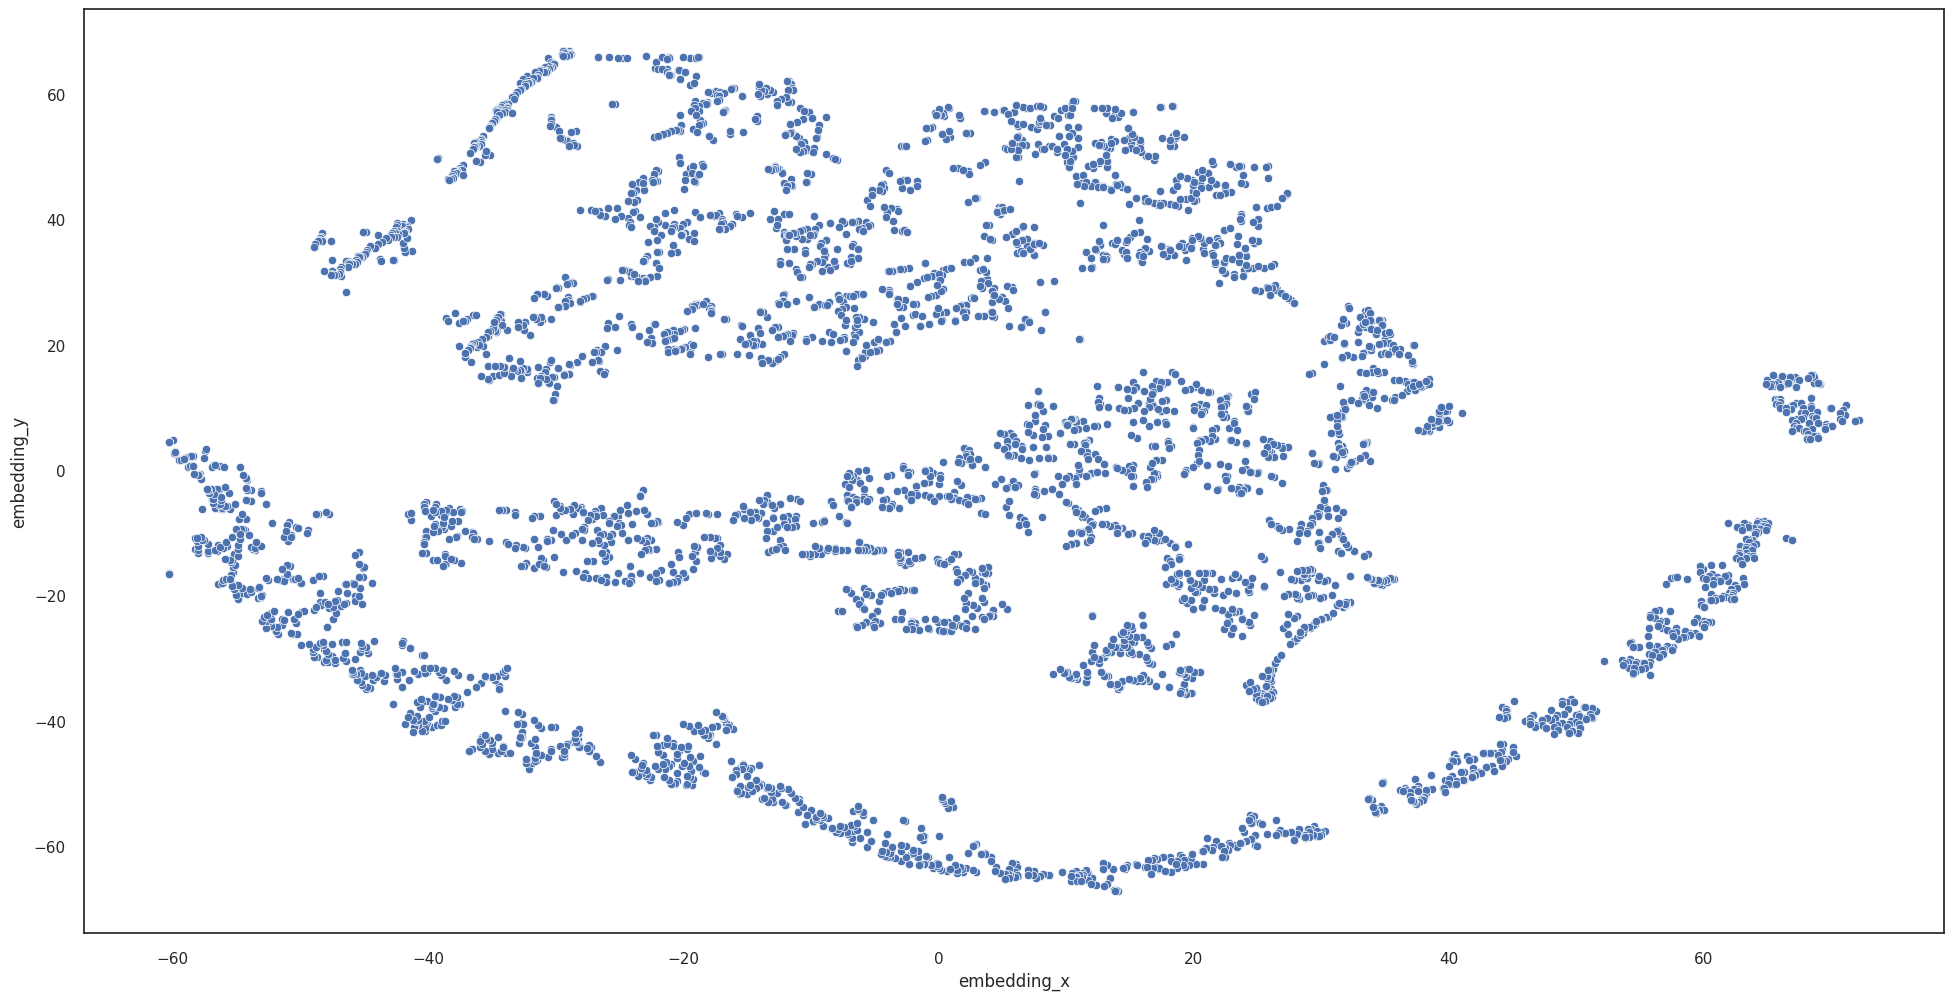

In [80]:
# Instancing
reducer = TSNE( n_components=2, n_jobs=-1, random_state=0 )

# Training
embedding = reducer.fit_transform( X[all_cols] )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# t-SNE plot
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_tsne );

## <font color='darkorange'> UMAP </font>

UMAP (Uniform Manifold Approximation and Projection) is a machine learning technique used for dimensionality reduction and visualization of high-dimensional data. It is similar to t-SNE, but it uses a different mathematical approach to preserve the global structure of the data. UMAP maps the high-dimensional data into a lower-dimensional space while maintaining the local and global structure of the data. This means that UMAP is useful for visualizing complex datasets in two or three dimensions, while preserving the relationships between the data points. UMAP has been successfully used in a variety of applications such as image and text analysis, genomics, and social network analysis.

**n_neighbours**

In UMAP, the n_neighbors parameter is used to control the balance between preserving the global structure of the data and capturing the local structure. It refers to the number of nearest neighbors that UMAP uses to construct a weighted graph of the input data.

A higher value of n_neighbors leads to more global structure being preserved, but may obscure more of the fine-grained, local structure. Conversely, a lower value of n_neighbors may lead to a more detailed representation of the local structure, but may fail to capture the larger-scale structure of the data.

**min_dist**

In UMAP, the min_dist parameter is used to control how tightly the algorithm should pack points together in the low-dimensional space. It refers to the minimum distance between points in the low-dimensional embedding.

A lower value of min_dist leads to more tightly packed clusters in the low-dimensional space, but may also cause points to be artificially pushed apart. Conversely, a higher value of min_dist allows for more separation between points, but may lead to more diffuse clusters.

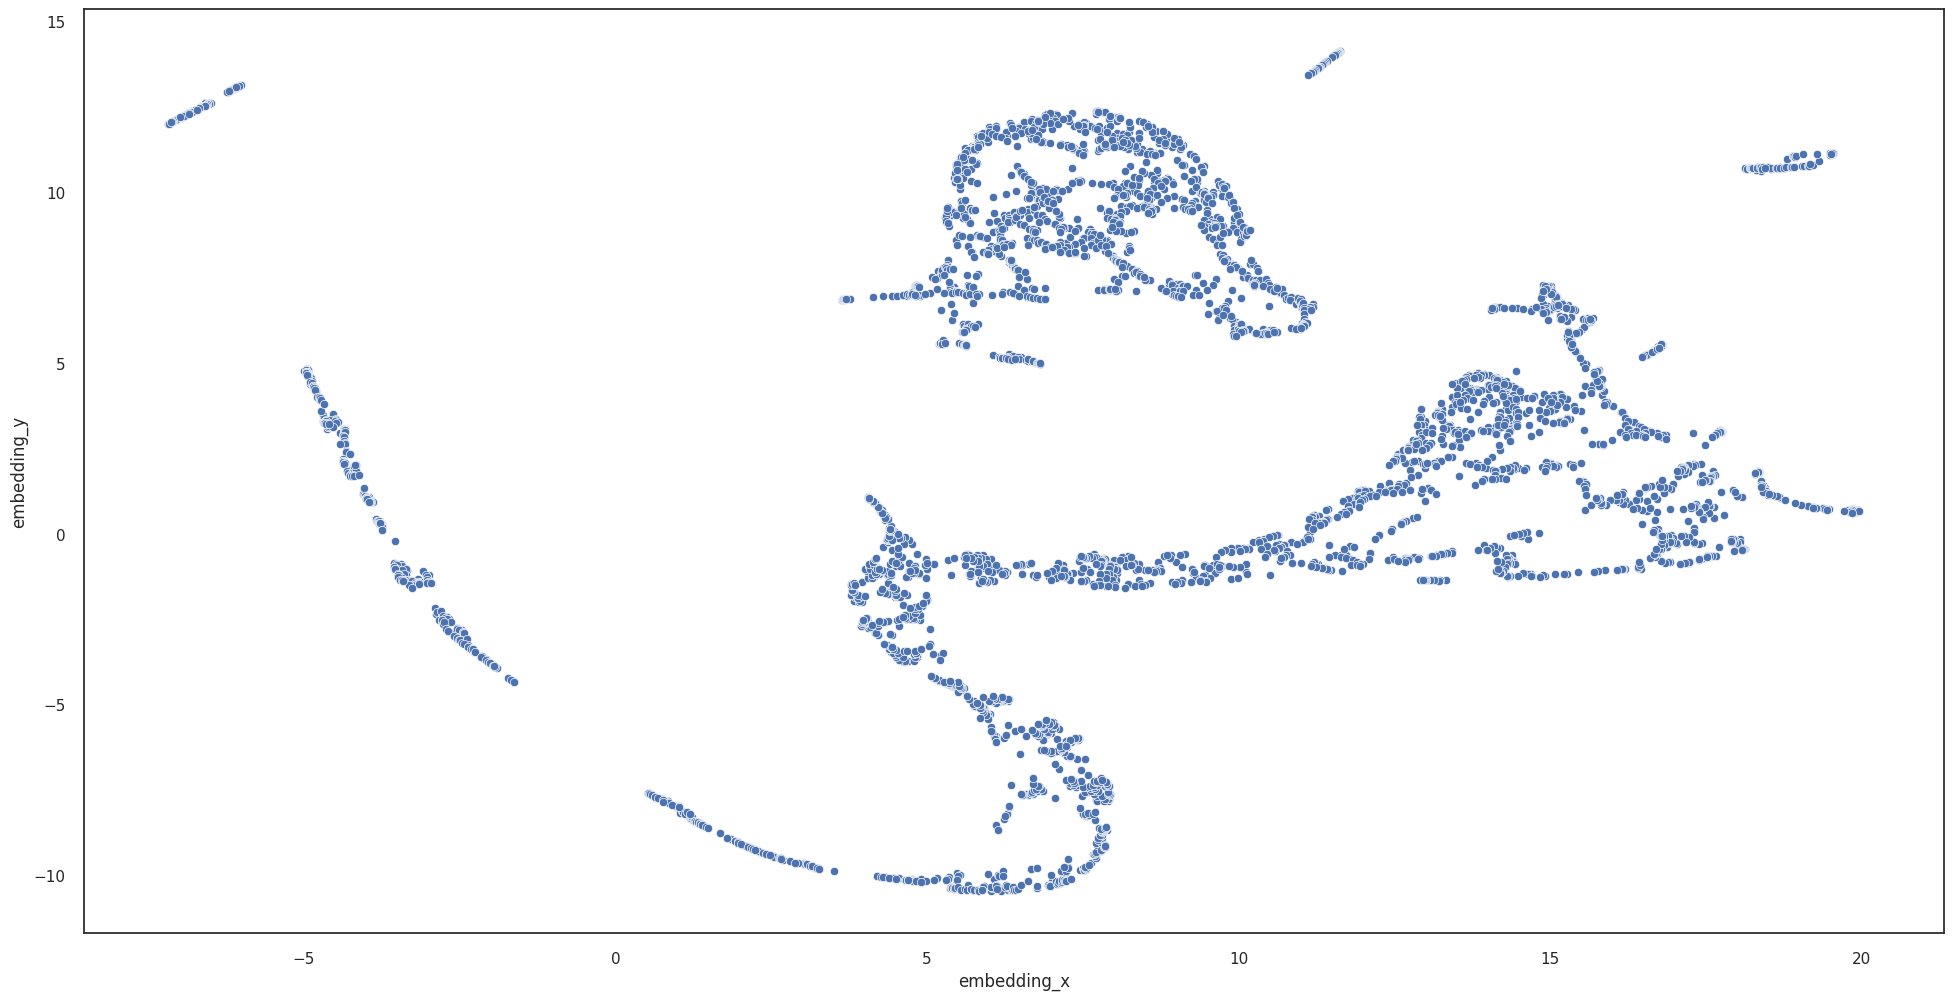

In [81]:
reducer = umap.UMAP( n_neighbors=15, min_dist=0.1, random_state=0 )
embedding = reducer.fit_transform(X[all_cols] )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_umap );

## <font color='darkorange'> Tree-Based Embedding </font>

Tree-based Embedding for clustering is a technique that uses the leaves of decision trees as features to group data. The main idea is to create a low-dimensional representation of the data, where each instance is mapped to a feature vector based on the leaves of the trees.

The Tree-based Embedding creation process involves the following steps:

- Train a decision tree model, such as Random Forest, using the original data.

- For each instance of data, traverse the tree and determine the leaf on which it falls.

- Create a feature vector for each instance, where each vector element represents a leaf in the tree.

- Concatenate the feature vectors of all instances, forming a new data matrix that represents the Tree-based Embedding.

Once the Tree-based Embedding has been obtained, it is possible to apply clustering techniques, such as the K-means algorithm, on the feature vectors to identify groups of similar instances. The idea is that instances that map to the same leaves in decision trees tend to have similar characteristics and therefore can be grouped together.

Using Tree-based Embedding for clustering can be an effective approach, especially when the data has a hierarchical structure or when the original features are not suitable for the clustering task. This technique allows you to capture relevant information from the decision tree model and apply it in the clustering process. However, it is important to adjust the parameters of the decision tree model and the clustering algorithm to obtain satisfactory results.

In [82]:
# Split X and y
X_train = X[cols_selected]
y_train = X.gross_revenue

# Intancing
rf = RandomForestRegressor( n_estimators=100, random_state=0, criterion='squared_error')

# Training
rf.fit(X_train, y_train)

# Leaf
df_rf = pd.DataFrame( rf.apply( X_train ) )

# Show the tree-based embedding
df_rf.head()

0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99
0  5171  4279  5144  4194  5099  5302  5083  5323  5195  5296  5186  4719  4667  5414  5196  5179  4990  5205  5182  5087  4677  5039  5043  4208  4385  5132  5227  5243  5373  4127  5330  5350  5286  5231  5143  4406  4590  4843  5180  4986  5298  4628  4336  5008  5103  5269  5194  5150  5144  5311  5293  5176  4848  5036  5291  5301  5340  5157  4713  4885  4408  4852  5237  4560  4865  5245  5290  5271  5286  5178  4943  4432  5378  5258  4582  4973  5260  5179  4673  4801  5276  5300  4736  4634  5251  5203  5241  4591  5005  5261  5385  5309  5212  4163  4907  5302  5262  4763  4238  4905
1  5088  4739  4827  4809  4573  3933  4569  4655  4202  4280  4327  5006  4907  4801  4882  4638  4751  4396  4509  4801  4899  4688  4809  4515  4863  4491  4757  4579  4598  4700  4951  4900  4881  4803  5058  4717  4787  4587  4381  4745  3978  4870  4683  4538  5055  4848  4391  4828  4798  4877  4628  4765  4631  4850  3874  4672  4193  4849  4937  4002  4673  4755  4308  4826  4542  4480  4753  4269  4632  4540  4351  5197  4795  4821  4789  4137  4332  4747  5058  4350  4235  4723  5081  4873  3919  4216  4419  4818  4180  4352  4865  4482  4652  4827  4539  4361  4315  4499  4893  4729
2  5224  5341  4952  4981  4947  5154  5040  5221  5026  5198  5213  5187  5059  5013  4985  4955  4961  4903  5103  4945  5082  4872  4989  5293  5074  5063  5039  5095  5294  4785  5084  5184  4985  5119  5201  5053  5287  5113  5275  4920  5163  5003  5297  4866  5204  5109  5096  4929  4928  4962  5121  4892  5127  4980  5181  4841  5217  4949  5316  5203  5069  4975  5142  5131  5211  5125  4885  4953  5096  5227  4900  5274  5011  5195  4934  4865  5173  5080  5345  5070  5119  4808  5316  5154  5136  5102  4956  4981  4880  5105  4999  5129  5285  4972  5215  5155  5198  5065  5090  5207
3  1383  2255  2769  1897  1161  1627  1838  1925  1876  1170  1476  2933  1875  1597  1590  1823  1966  1605  1195  1798  2474  1533  1516  1380  2063  1949  2475  1415  1223  1777  1932  1354  2114  1966  2014  2029  2285  1145  1459  1955  1567  1373  2020  1879  1622  2538  1996  1898  2184  1066  1354  1359  1888  1358  1378  2065  2210  1325  1090  2435  1538  1914  1447  1771  1515  2048  1629  1893  1566  1488  1684  1476  2089  2639  2371  1980  1284  1231  1645  1268  2006  1639  1751  2022  2433  1795  1918  2235  1705  1534  1789  1905  2030  2008  1422  2049  1160  1347  1324  2399
4   771   320   261   649   807   623  1357   682   507   835   116   279   629   427   121   777   664   494   740   409   442    54   594   978   509   686   872   809   807   674   654   805   601   676   561   696   291   752   854   397   643   802   631   585   680   751   535   741   395   299   252   359   141    53   254   722   639   344   110   838   364   687   861   601   251   368   639   700   777   586   277   934   655   367   337   710   397   818   537   695   120   461   406   718   392   636   630   301   664   757  1075   642   661   502   776   633   803   723   843   816

### <font color = 'darkorange'> UMAP

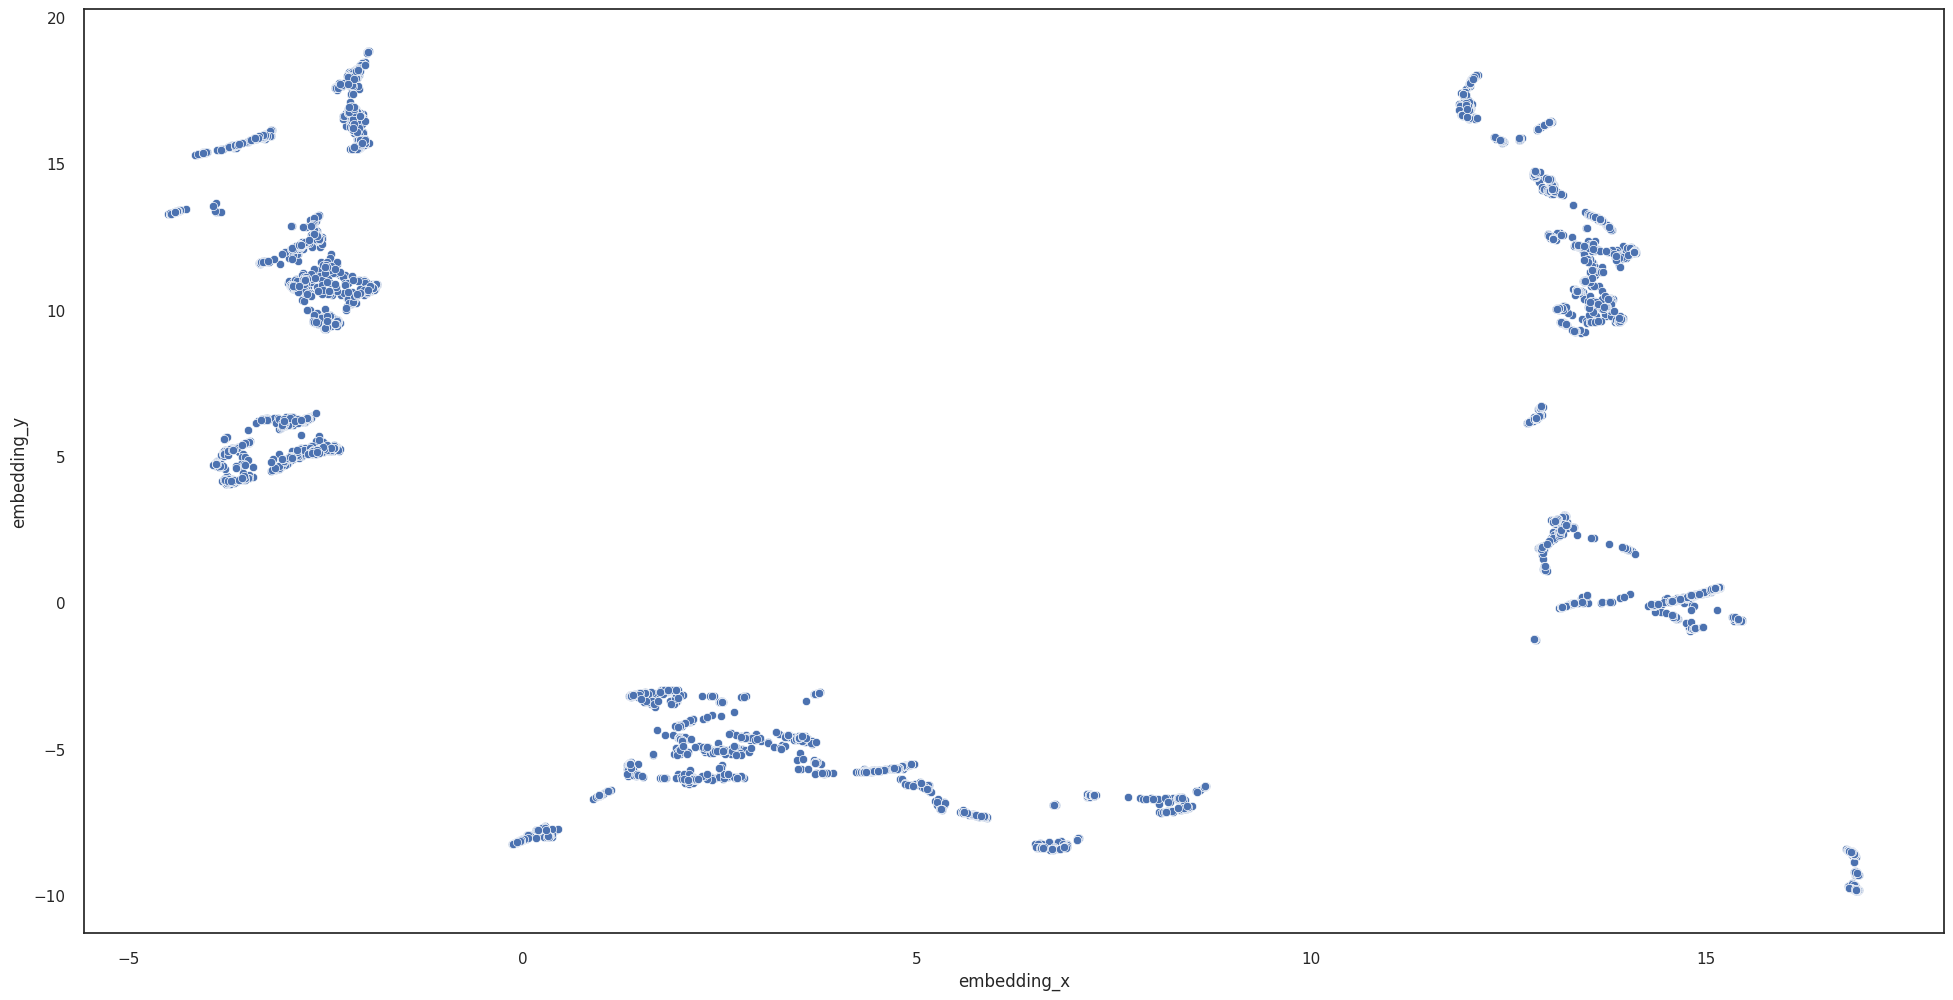

In [83]:
reducer = umap.UMAP( random_state=0, n_neighbors=60, min_dist=0.01  )
embedding = reducer.fit_transform( df_rf )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_umap );

# <font color='darkorange'>8.0. Hyperparameter Fine-Tuning
## Determining the Optimal Number of Clusters</font>

Selecting the optimal number of clusters is crucial when applying a clustering algorithm to a dataset. Some clustering algorithms, such as K-means, require the user to specify the number of clusters (k) to be generated. However, determining the appropriate number of clusters is often a subjective and challenging task in cluster analysis.

To evaluate the number of clusters, we can use the Silhouette Score:

The Silhouette Score is a metric commonly used to assess the performance of clustering algorithms. It measures how well each data point fits into its assigned cluster compared to other clusters. The Silhouette Score ranges from -1 to 1, where a score of 1 indicates that the data point is well-matched to its own cluster and poorly-matched to neighboring clusters. Conversely, a score of -1 indicates the opposite, and a score of 0 suggests that the data point lies on the boundary between two clusters. A higher Silhouette Score indicates a more appropriate clustering, while a lower score suggests that the data points may have been assigned to incorrect clusters. Therefore, the Silhouette Score is commonly used to determine the optimal number of clusters for a given dataset.

## <font color='darkorange'> 8.1. KMeans</font>
K-Means Clustering may be the most widely known clustering algorithm and involves assigning examples to clusters in an effort to minimize the variance within each cluster. It's a centroid-based algorithm and the simplest unsupervised learning algorithm. The algorithm tries to minimize the variance of data points within a cluster. It's also how most people are introduced to unsupervised machine learning.

K-means++ (default init parameter for K-Means in sklearn) is the algorithm which is used to overcome the drawback posed by the k-means algorithm. The goal is to spread out the initial centroid by assigning the first centroid randomly then selecting the rest of the centroids based on the maximum squared distance. The idea is to push the centroids as far as possible from one another.

Although the initialization in K-means++ is computationally more expensive than the standard K-means algorithm, the run-time for convergence to optimum is drastically reduced for K-means++. This is because the centroids that are initially chosen are likely to lie in different clusters already.

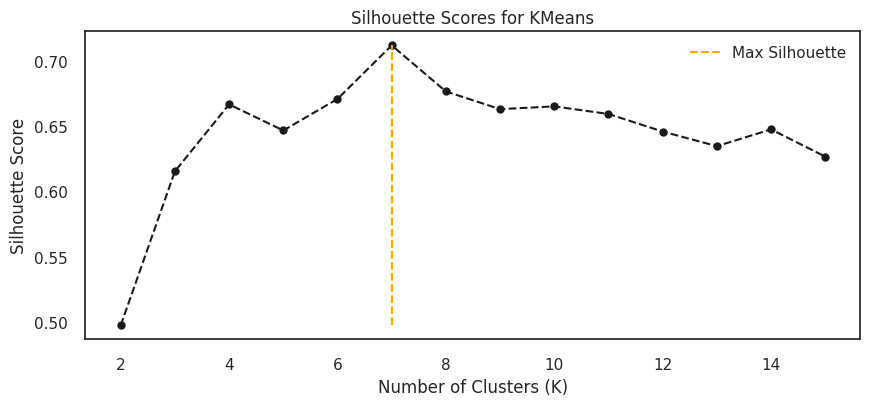

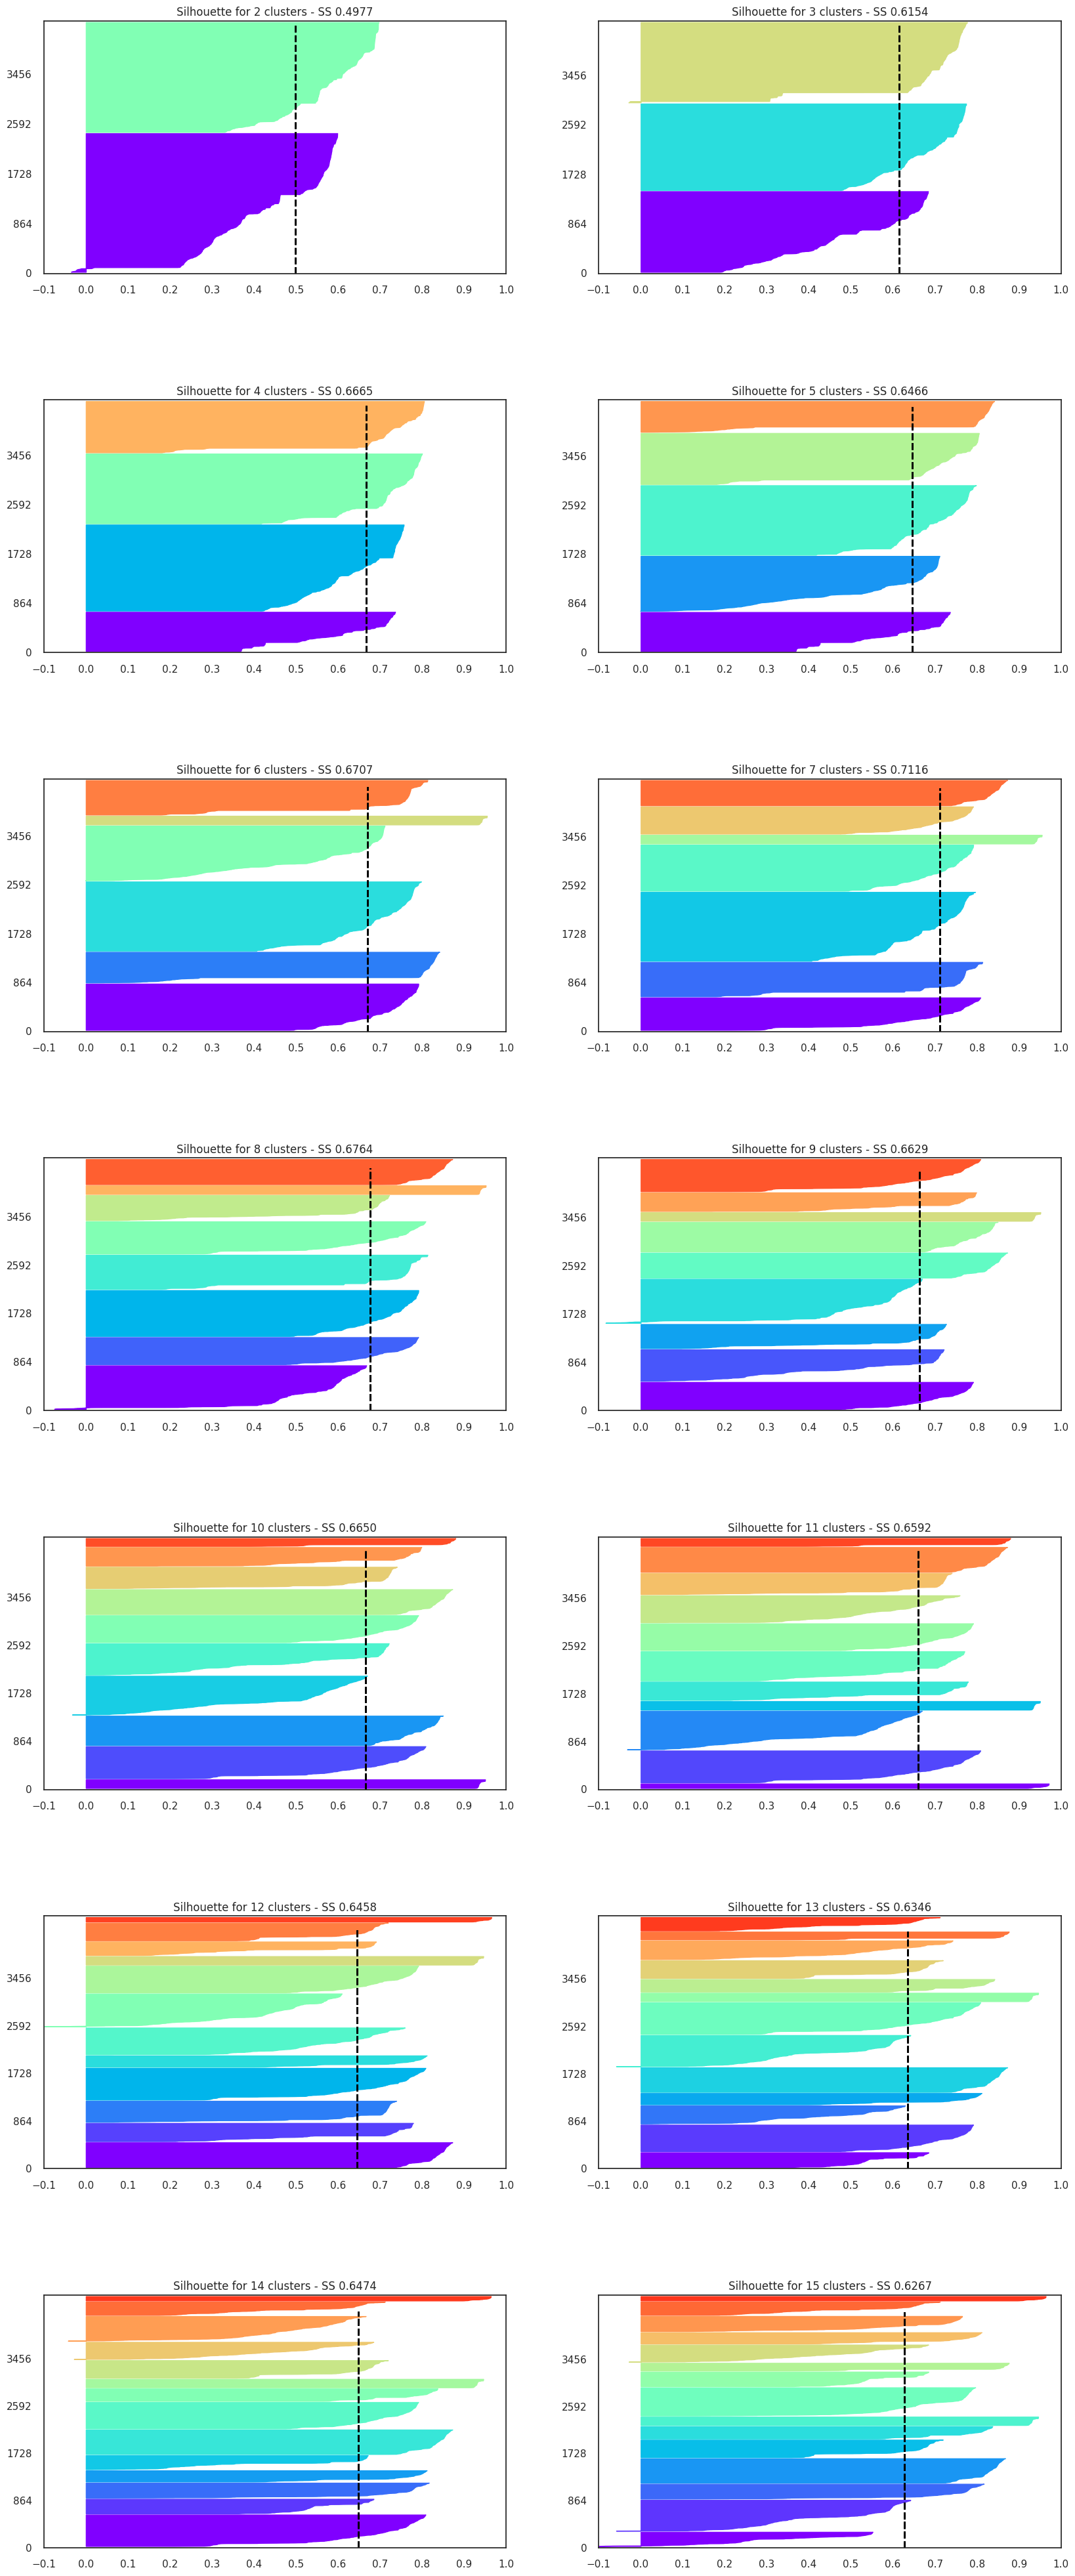

In [84]:
cluster_list = np.arange(2, 16, 1)
data = df_umap.copy()
labels_at_k, sil_scores_at_k = [], []
silhouette_plots = []

fig, ax = plt.subplots(int(np.ceil(len(cluster_list) / 2)), 2, figsize=(20, 50))
fig.subplots_adjust(hspace=0.5)

min_x_tick = 0

for cluster in cluster_list:
    q, mod = divmod(cluster, 2)

    # Set the x-axis and y-axis limits for each subplot
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(data) + (cluster + 1) * 20])

    # Perform KMeans clustering with the specified number of clusters
    model = KMeans(init='k-means++', random_state=0, n_clusters=cluster)
    model.fit(data)
    labels = model.labels_
    labels_at_k.append(cluster)
    ss_score = silhouette_score(data, labels=labels, metric='euclidean')
    sil_scores_at_k.append(ss_score)
    samples_silhouette_values = silhouette_samples(data, labels)

    y_lower = 20

    for i in range(cluster):
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        ith_samples_silhouette_values.sort()
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.get_cmap('rainbow')
        color = cmap(i / cluster)

        # Plot the silhouette values for each cluster
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values, color=color, alpha=1)
        ax[q-1, mod].vlines(ss_score, -10, data.shape[0], linestyle='--', color='black', linewidth=2, label="Avg Sil Score" if i == 0 else "")
        ax[q-1, mod].set_title(f'Silhouette for {cluster} clusters - SS {ss_score:.4f}')
        ax[q-1, mod].set_ylim([-10, len(data) + (cluster + 1) * 20])
      
        x_tick = np.round(min(samples_silhouette_values), 1)

        y_lower = y_upper + 20

    if x_tick < min_x_tick:
        min_x_tick = x_tick

    # Store the silhouette plot for later use
    silhouette_plots.append(ax[q-1, mod])

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(cluster_list, sil_scores_at_k, 'k--', marker='o')
ax.vlines(cluster_list[np.argmax(sil_scores_at_k)], sil_scores_at_k[np.argmin(sil_scores_at_k)],
          sil_scores_at_k[np.argmax(sil_scores_at_k)], linestyle='--', color='orange', label='Max Silhouette')

ax.set_ylabel('Silhouette Score')
ax.set_xlabel('Number of Clusters (K)')
ax.set_title(f'Silhouette Scores for {type(model).__name__}')
ax.legend()

# Plot the silhouette plots with adjusted ticks and labels
for silhouette_plot in silhouette_plots:
    plt.sca(silhouette_plot)
    plt.yticks(np.arange(0, len(data), int(len(data)/5)))

    plt.xlim([min_x_tick, 1])
    plt.xticks(np.arange(x_tick, 1.05, 0.1))

plt.show()

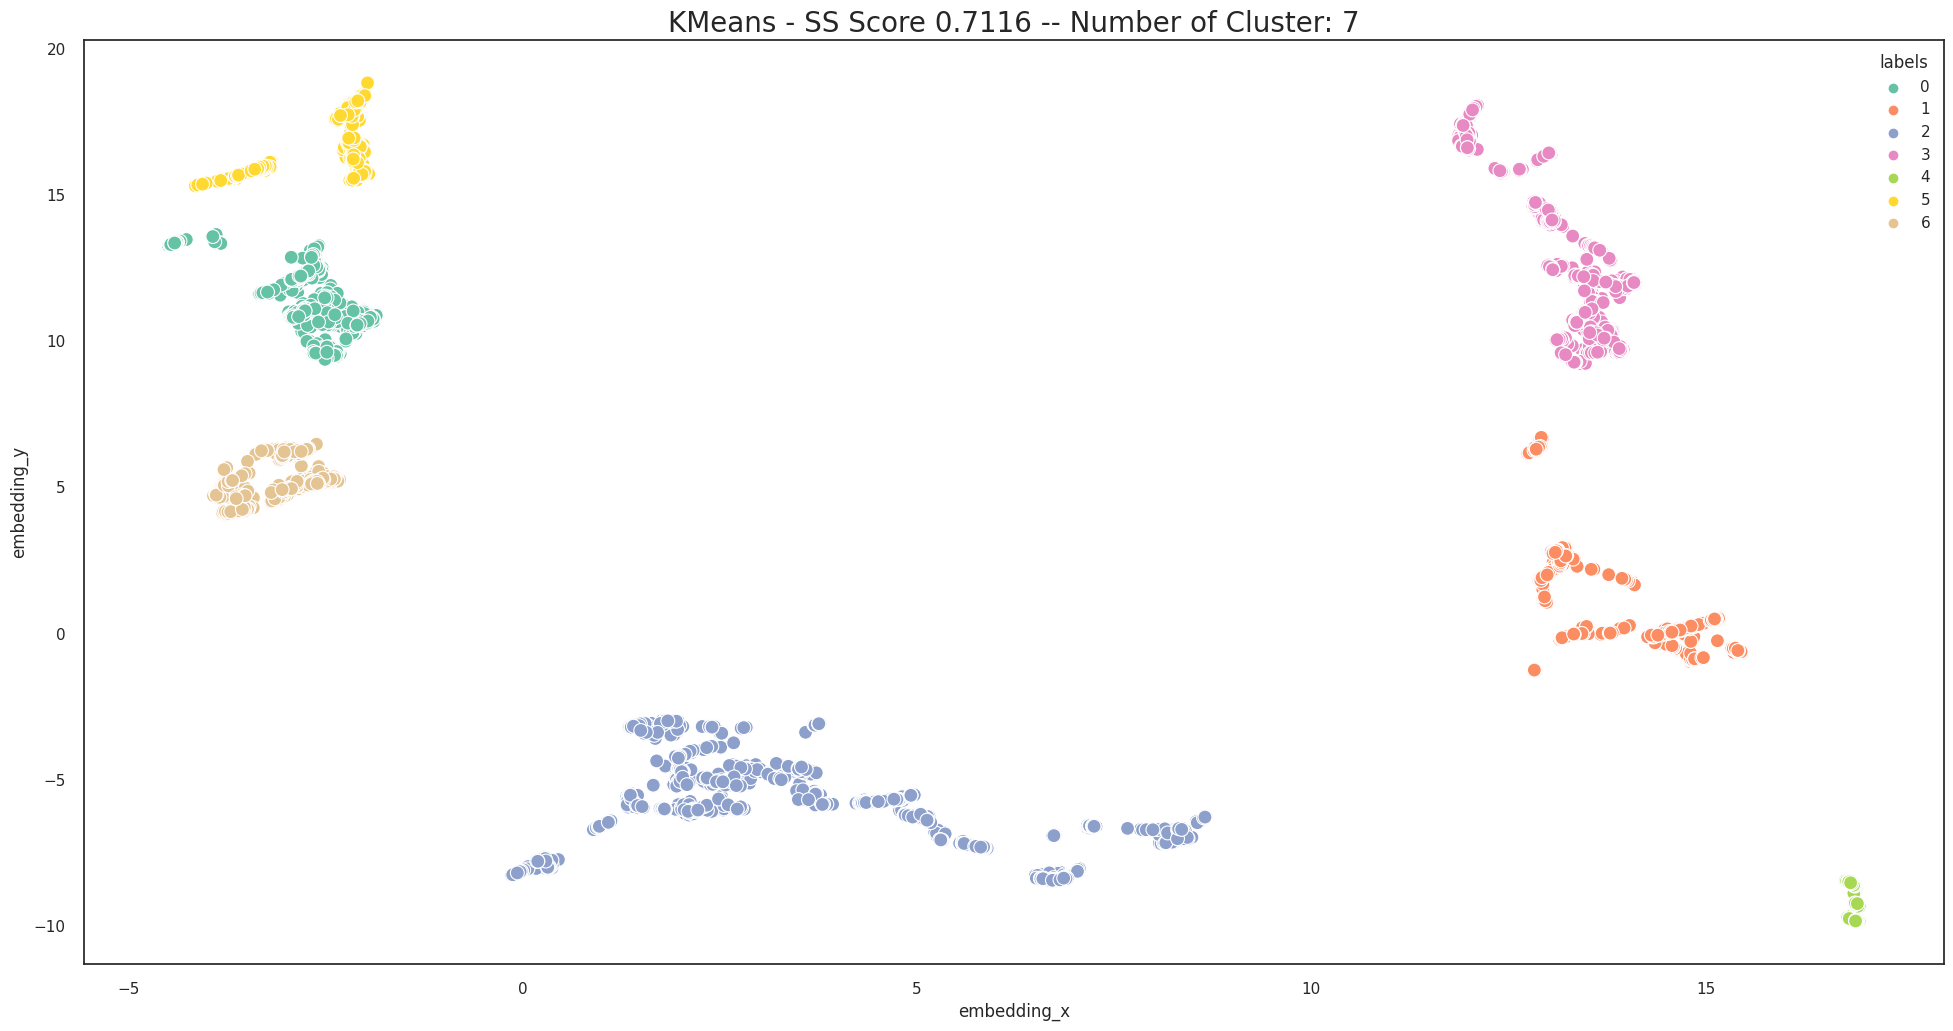

In [85]:
model = KMeans(init="k-means++", random_state=0, n_clusters=7)
model.fit(data)
labels = model.predict(data)
ss_score = silhouette_score(data, labels=labels, metric='euclidean')

data['labels'] = labels
cluster = data.labels.nunique()

sns.scatterplot(data=data,x='embedding_x', y='embedding_y', hue='labels', palette='Set2', s=100);
plt.title(f"KMeans - SS Score {ss_score:.4f} -- Number of Cluster: {cluster}", fontsize=20);

## <font color='darkorange'> 8.2. GMM </font>

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means, but because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments.

The Gaussian mixture model uses multiple Gaussian distributions to fit arbitrarily shaped data.

There are several single Gaussian models that act as hidden layers in this hybrid model. So the model calculates the probability that a data point belongs to a specific Gaussian distribution and that's the cluster it will fall under.

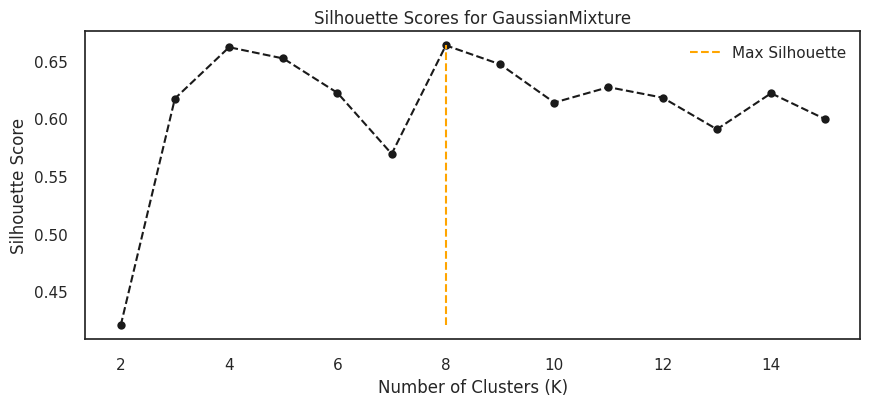

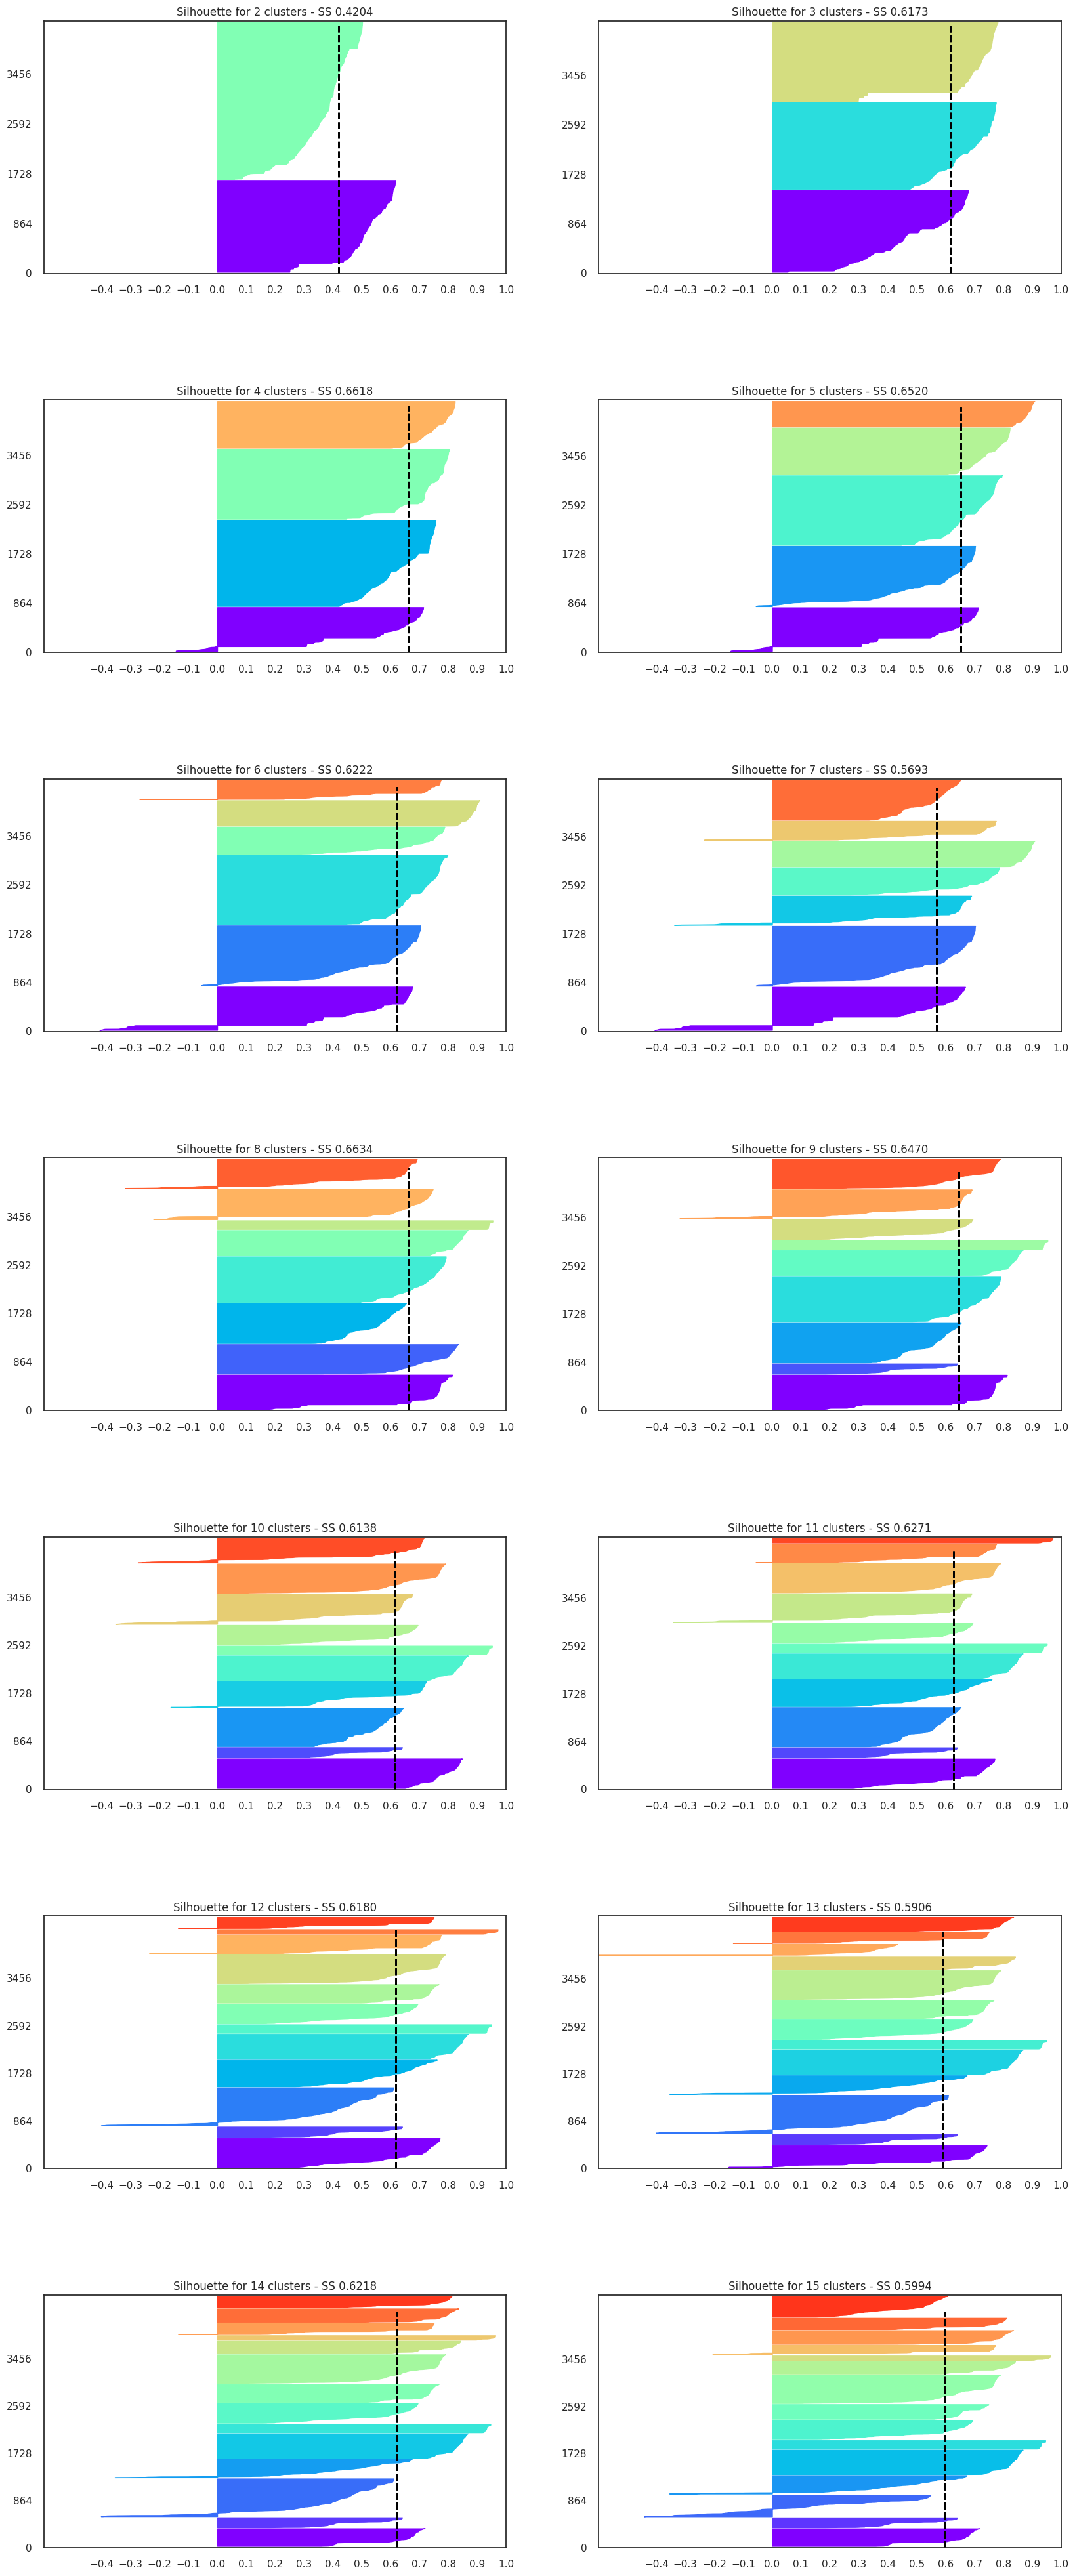

In [86]:
cluster_list = np.arange(2, 16, 1)
data = df_umap.copy()
labels_at_k, sil_scores_at_k = [], []
silhouette_plots = []

fig, ax = plt.subplots(int(np.ceil(len(cluster_list) / 2)), 2, figsize=(20, 50))
fig.subplots_adjust(hspace=0.5)

min_x_tick = 0

for cluster in cluster_list:
    q, mod = divmod(cluster, 2)

    # Set the x-axis and y-axis limits for each subplot
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(data) + (cluster + 1) * 20])

    # Perform GMM clustering with the specified number of clusters
    model = GaussianMixture(random_state=0, n_components=cluster)
    model.fit(data)
    labels = model.predict(data)
    labels_at_k.append(cluster)
    ss_score = silhouette_score(data, labels=labels, metric='euclidean')
    sil_scores_at_k.append(ss_score)
    samples_silhouette_values = silhouette_samples(data, labels)

    y_lower = 20

    for i in range(cluster):
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        ith_samples_silhouette_values.sort()
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.get_cmap('rainbow')
        color = cmap(i / cluster)

        # Plot the silhouette values for each cluster
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values, color=color, alpha=1)
        ax[q-1, mod].vlines(ss_score, -10, data.shape[0], linestyle='--', color='black', linewidth=2, label="Avg Sil Score" if i == 0 else "")
        ax[q-1, mod].set_title(f'Silhouette for {cluster} clusters - SS {ss_score:.4f}')
        ax[q-1, mod].set_ylim([-10, len(data) + (cluster + 1) * 20])
      
        x_tick = np.round(min(samples_silhouette_values), 1)

        y_lower = y_upper + 20

    if x_tick < min_x_tick:
        min_x_tick = x_tick

    # Store the silhouette plot for later use
    silhouette_plots.append(ax[q-1, mod])

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(cluster_list, sil_scores_at_k, 'k--', marker='o')
ax.vlines(cluster_list[np.argmax(sil_scores_at_k)], sil_scores_at_k[np.argmin(sil_scores_at_k)],
          sil_scores_at_k[np.argmax(sil_scores_at_k)], linestyle='--', color='orange', label='Max Silhouette')

ax.set_ylabel('Silhouette Score')
ax.set_xlabel('Number of Clusters (K)')
ax.set_title(f'Silhouette Scores for {type(model).__name__}')
ax.legend()

# Plot the silhouette plots with adjusted ticks and labels
for silhouette_plot in silhouette_plots:
    plt.sca(silhouette_plot)
    plt.yticks(np.arange(0, len(data), int(len(data)/5)))

    plt.xlim([min_x_tick, 1])
    plt.xticks(np.arange(x_tick, 1.05, 0.1))

plt.show()

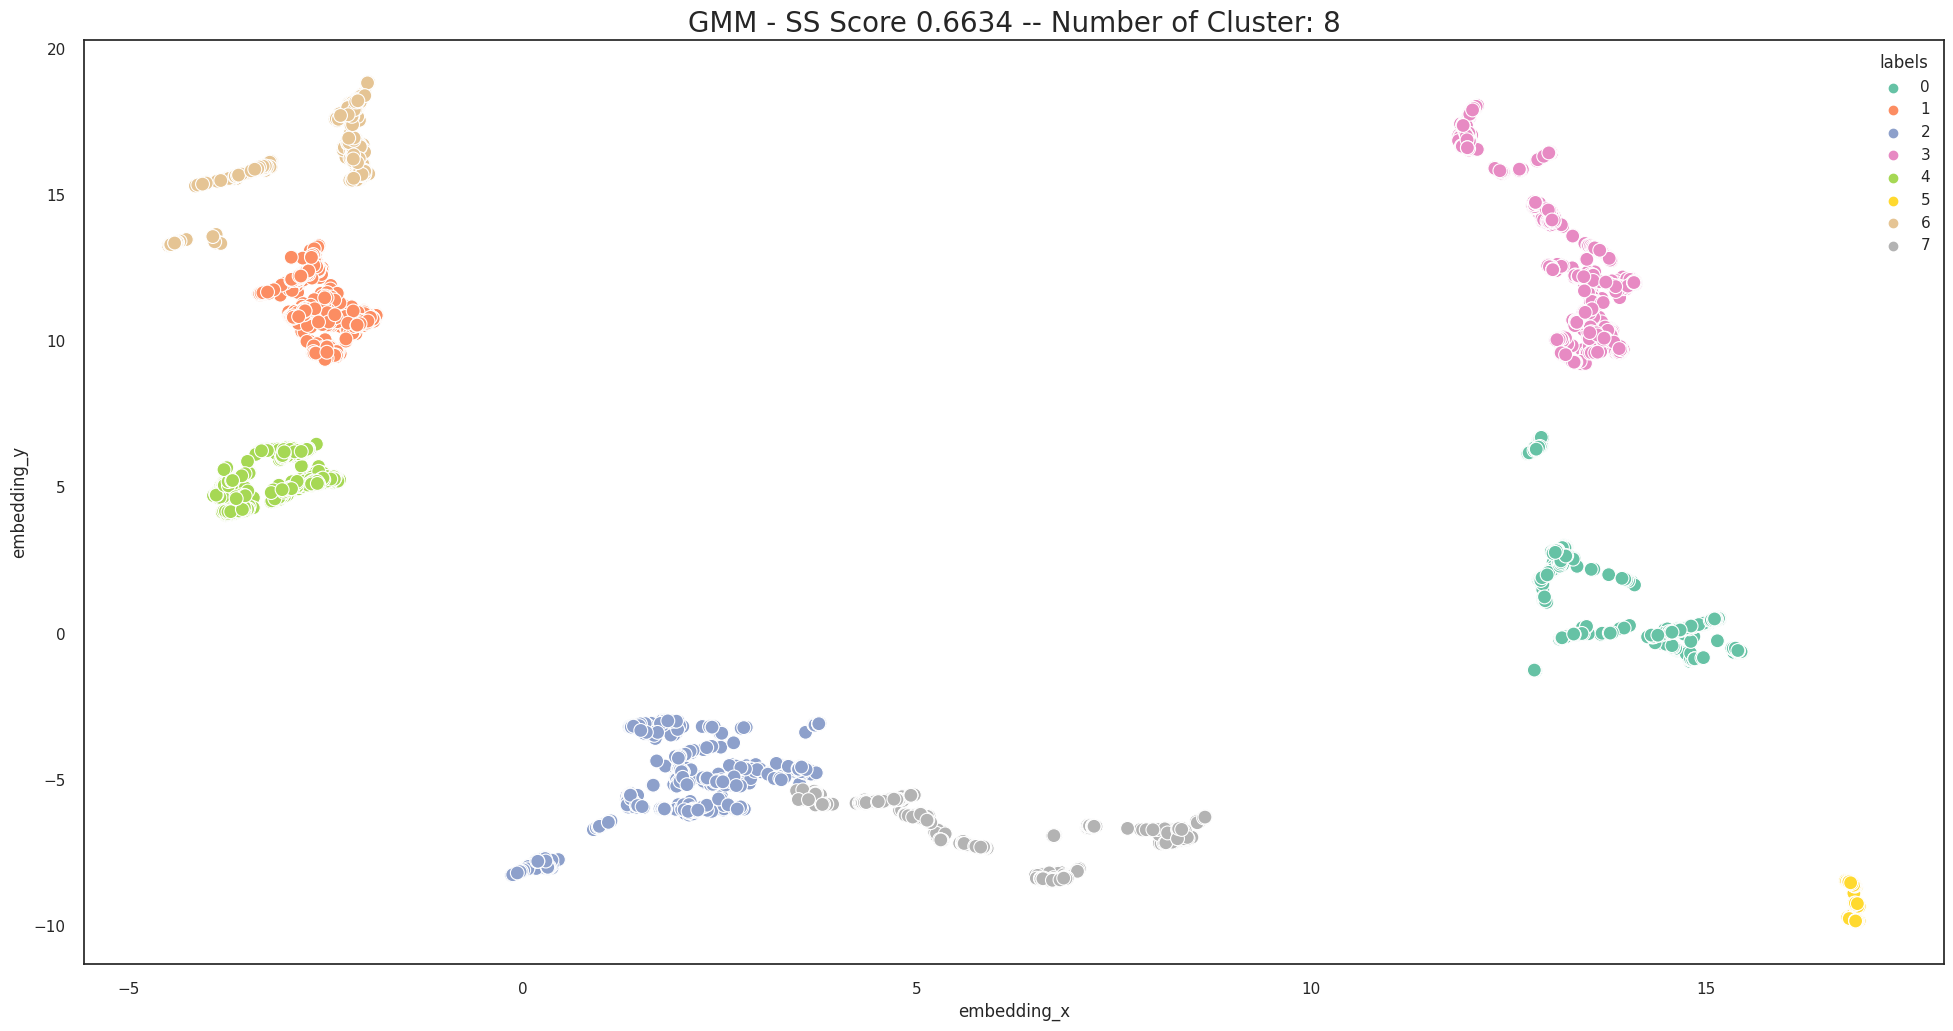

In [87]:
model = GaussianMixture(random_state=0, n_components=8)
model.fit(data)
labels = model.predict(data)
ss_score = silhouette_score(data, labels=labels, metric='euclidean')

data['labels'] = labels
cluster = data.labels.nunique()

sns.scatterplot(data=data,x='embedding_x', y='embedding_y', hue='labels', palette='Set2', s=100);
plt.title(f"GMM - SS Score {ss_score:.4f} -- Number of Cluster: {cluster}", fontsize=20);

## <font color='darkorange'> 8.3. Hierarchical Clustering </font>
Hierarchical clustering (also called hierarchical cluster analysis or HCA) is a method of cluster analysis that seeks to build a hierarchy of clusters. It's used to group objects in clusters based on how similar they are to each other. In general, the merges and splits are determined in a greedy manner. The results of hierarchical clustering are usually presented in a dendrogram.

Hierarchical clustering is particularly useful in situations where you have a few observations you are particularly interested in and you want to be able to identify observations that are similar to those observations.

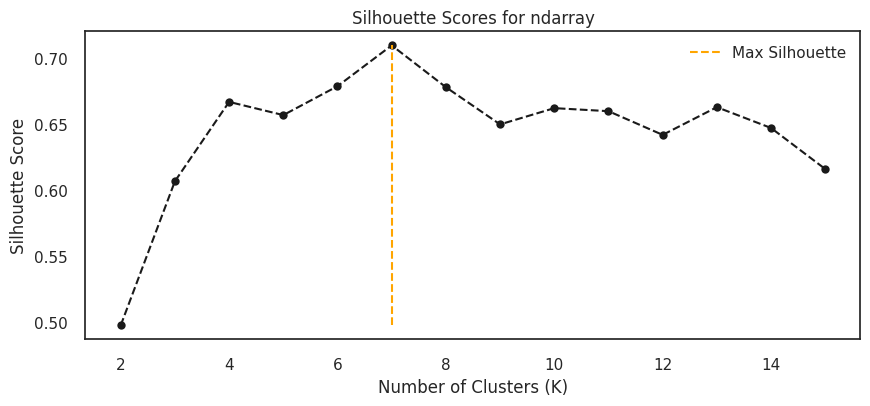

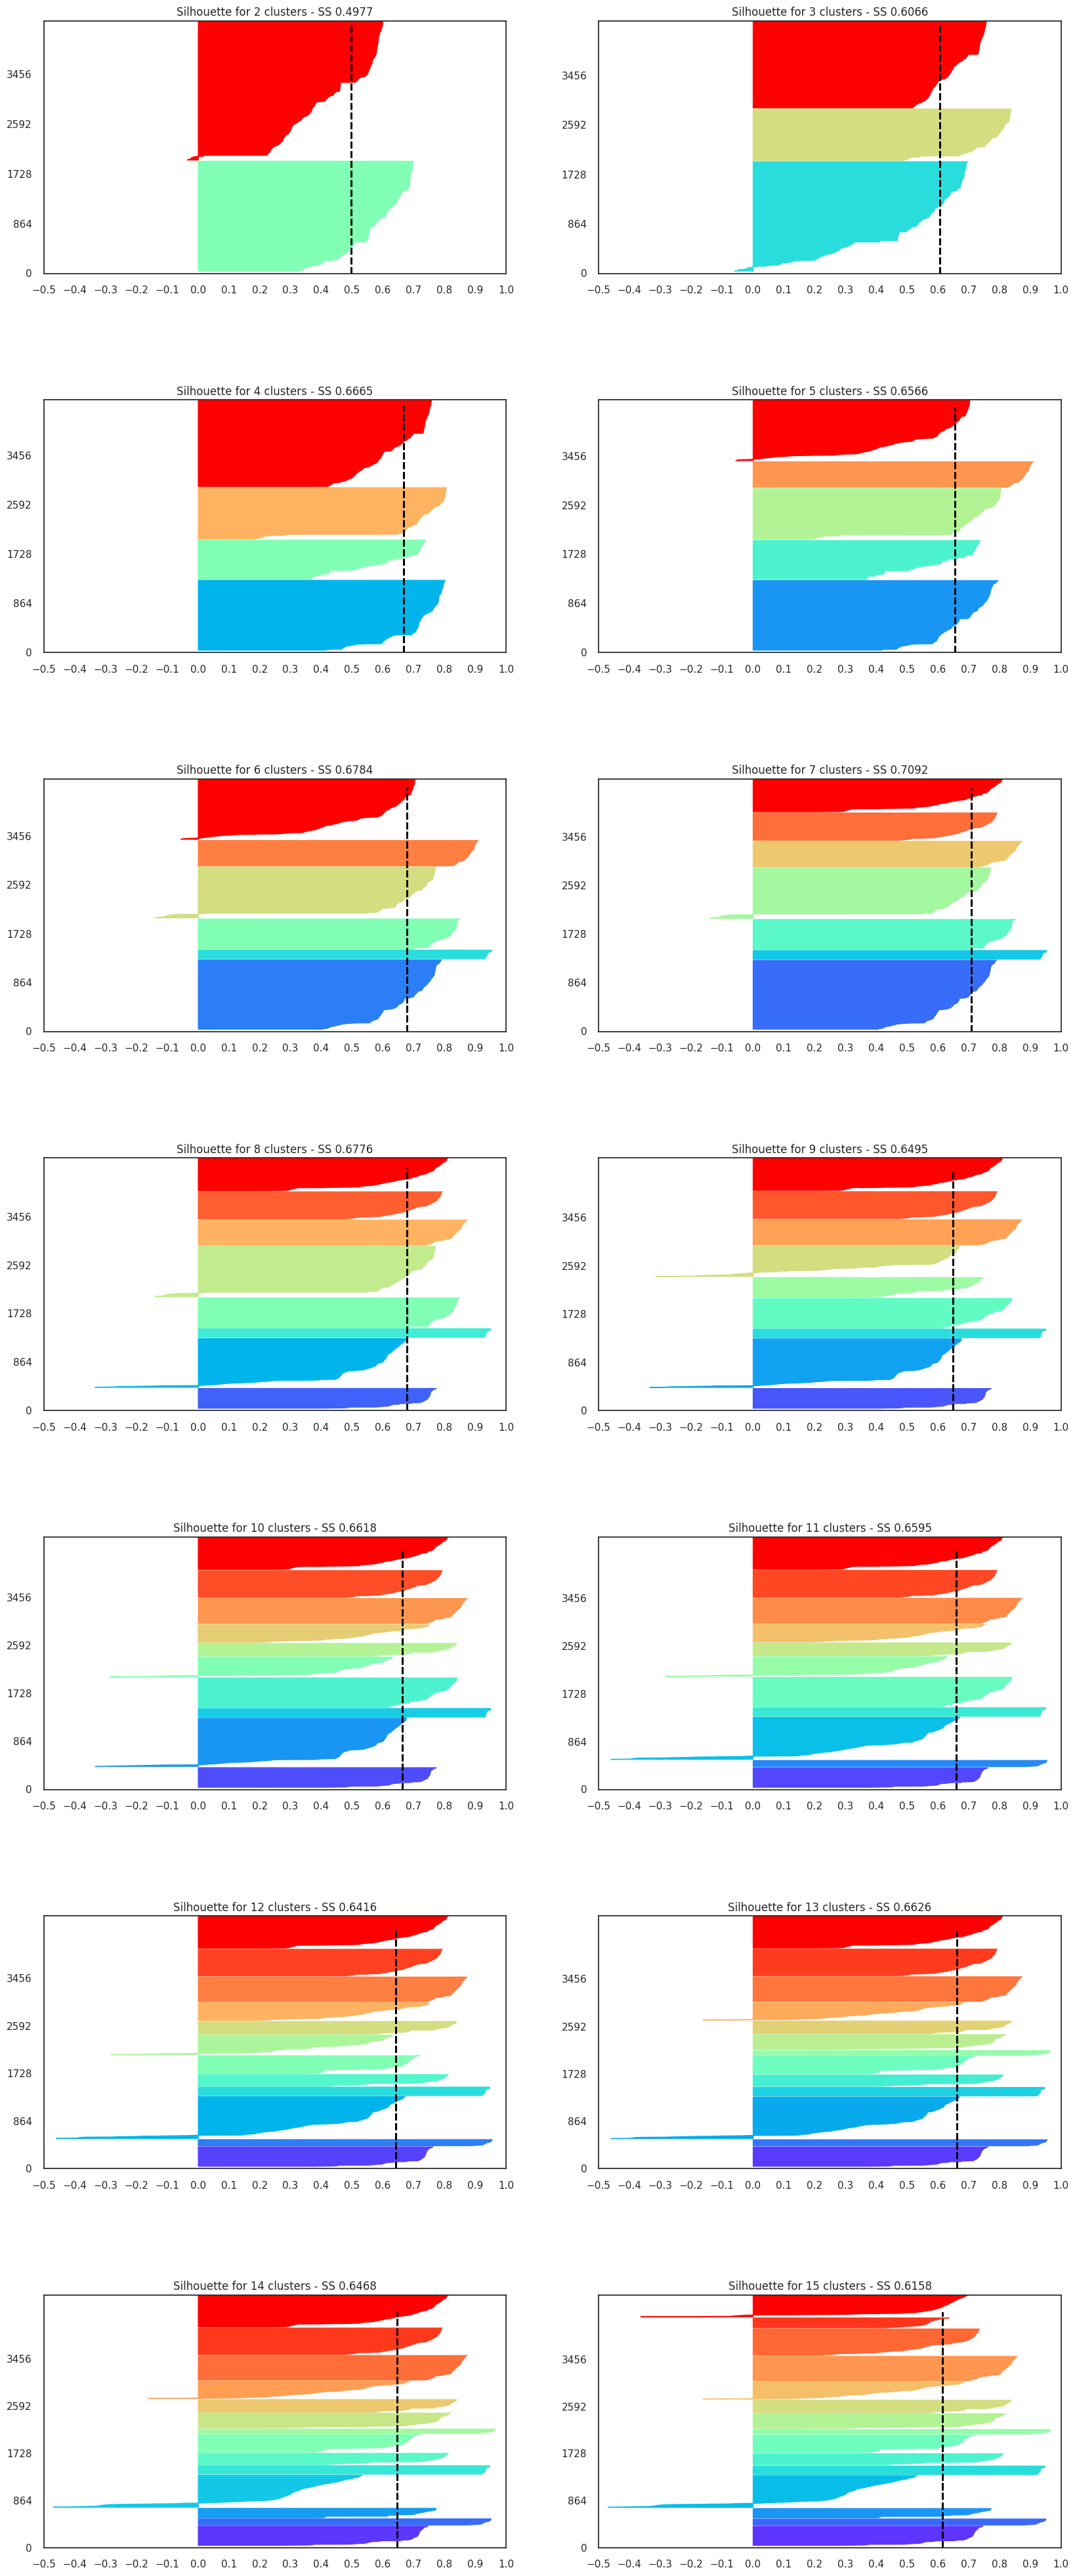

In [88]:
cluster_list = np.arange(2, 16, 1)
data = df_umap.copy()
labels_at_k, sil_scores_at_k = [], []
silhouette_plots = []

fig, ax = plt.subplots(int(np.ceil(len(cluster_list) / 2)), 2, figsize=(20, 50))
fig.subplots_adjust(hspace=0.5)

min_x_tick = 0

for cluster in cluster_list:
    q, mod = divmod(cluster, 2)

    # Set the x-axis and y-axis limits for each subplot
    ax[q-1, mod].set_xlim([-0.1, 1])
    ax[q-1, mod].set_ylim([0, len(data) + (cluster + 1) * 20])

    # Perform GMM clustering with the specified number of clusters
    model = linkage( data, 'ward' )
    labels = fcluster( model, cluster, criterion='maxclust' )
    labels_at_k.append(cluster)
    ss_score = silhouette_score(data, labels=labels, metric='euclidean')
    sil_scores_at_k.append(ss_score)
    samples_silhouette_values = silhouette_samples(data, labels)

    y_lower = 20

    for i in range(cluster+1):
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        ith_samples_silhouette_values.sort()
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.get_cmap('rainbow')
        color = cmap(i / cluster)

        # Plot the silhouette values for each cluster
        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values, color=color, alpha=1)
        ax[q-1, mod].vlines(ss_score, -10, data.shape[0], linestyle='--', color='black', linewidth=2, label="Avg Sil Score" if i == 0 else "")
        ax[q-1, mod].set_title(f'Silhouette for {cluster} clusters - SS {ss_score:.4f}')
        ax[q-1, mod].set_ylim([-10, len(data) + (cluster + 1) * 20])
      
        x_tick = np.round(min(samples_silhouette_values), 1)

        y_lower = y_upper + 20

    if x_tick < min_x_tick:
        min_x_tick = x_tick

    # Store the silhouette plot for later use
    silhouette_plots.append(ax[q-1, mod])

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(cluster_list, sil_scores_at_k, 'k--', marker='o')
ax.vlines(cluster_list[np.argmax(sil_scores_at_k)], sil_scores_at_k[np.argmin(sil_scores_at_k)],
          sil_scores_at_k[np.argmax(sil_scores_at_k)], linestyle='--', color='orange', label='Max Silhouette')

ax.set_ylabel('Silhouette Score')
ax.set_xlabel('Number of Clusters (K)')
ax.set_title(f'Silhouette Scores for {type(model).__name__}')
ax.legend()

# Plot the silhouette plots with adjusted ticks and labels
for silhouette_plot in silhouette_plots:
    plt.sca(silhouette_plot)
    plt.yticks(np.arange(0, len(data), int(len(data)/5)))

    plt.xlim([min_x_tick, 1])
    plt.xticks(np.arange(x_tick, 1.05, 0.1))

plt.show()

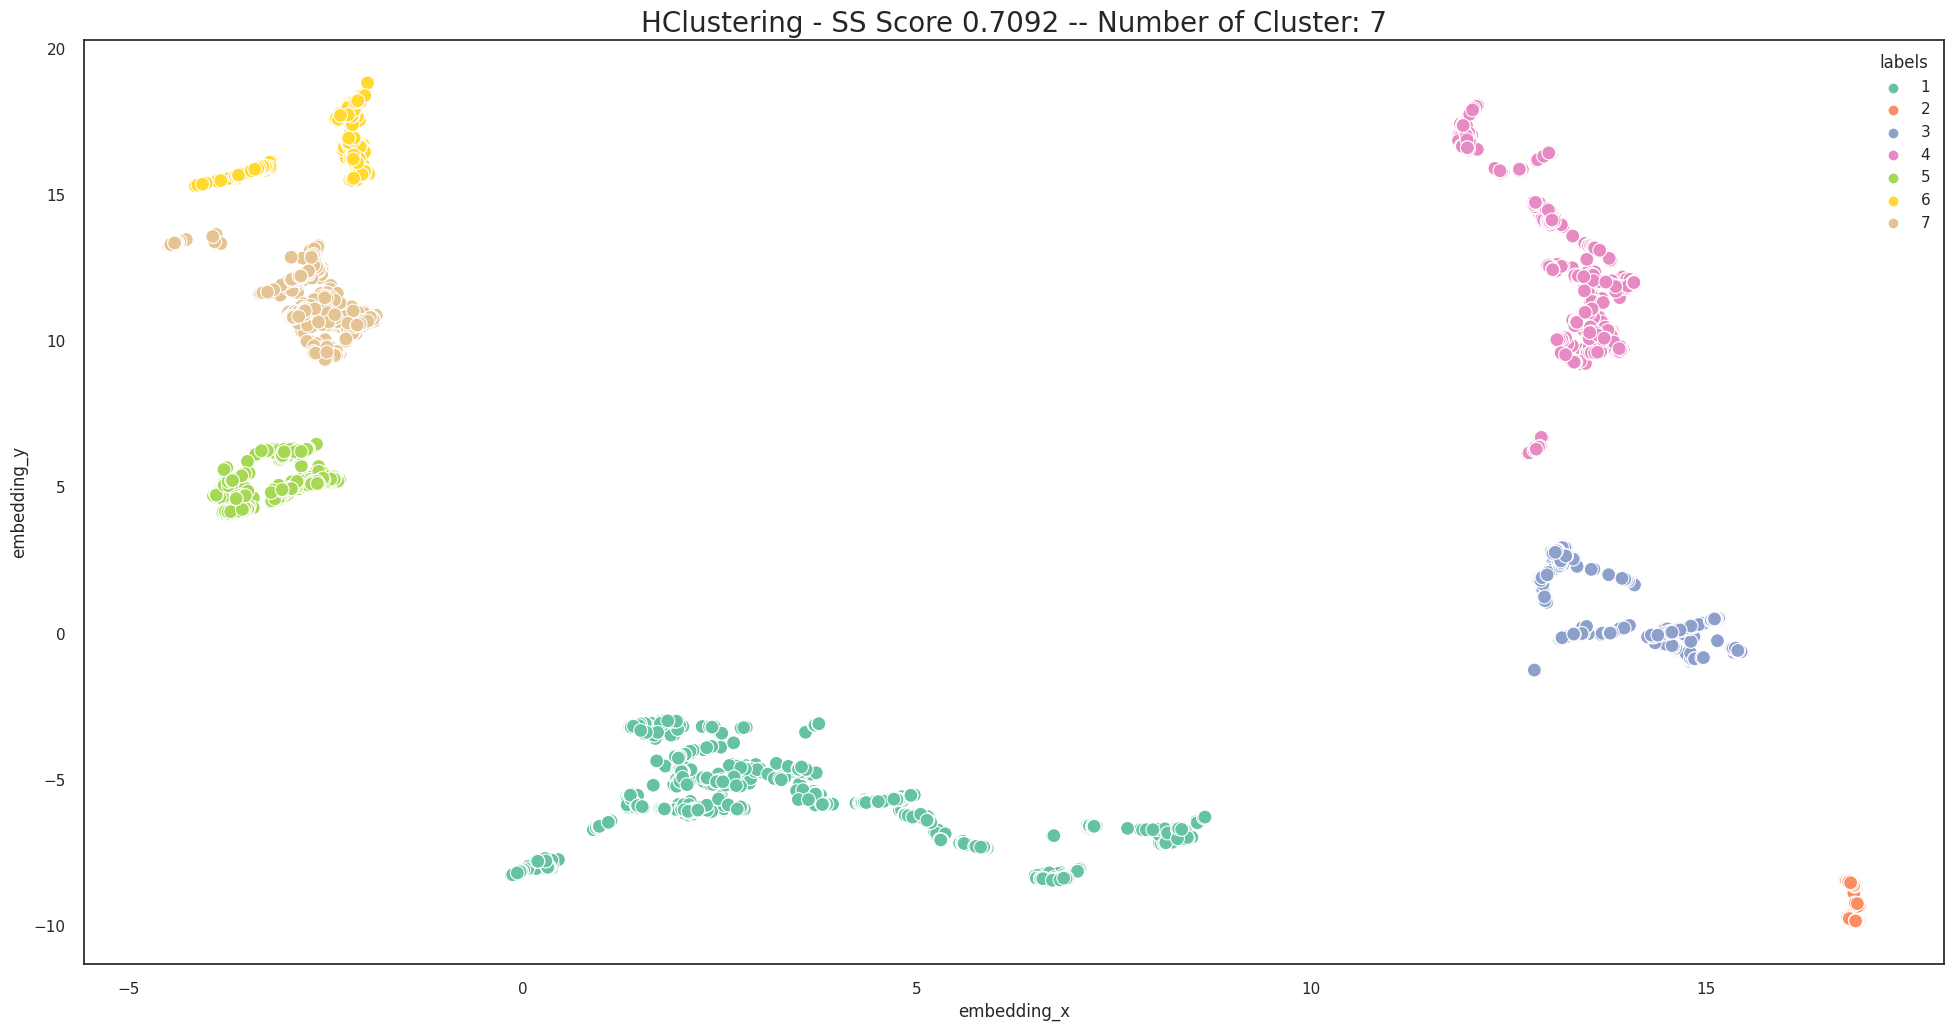

In [89]:
model = linkage( data, 'ward' )
labels = fcluster( model, 7, criterion='maxclust' )
ss_score = silhouette_score(data, labels=labels, metric='euclidean')

data['labels'] = labels
cluster = data.labels.nunique()

sns.scatterplot(data=data,x='embedding_x', y='embedding_y', hue='labels', palette='Set2', s=100);
plt.title(f"HClustering - SS Score {ss_score:.4f} -- Number of Cluster: {cluster}", fontsize=20);

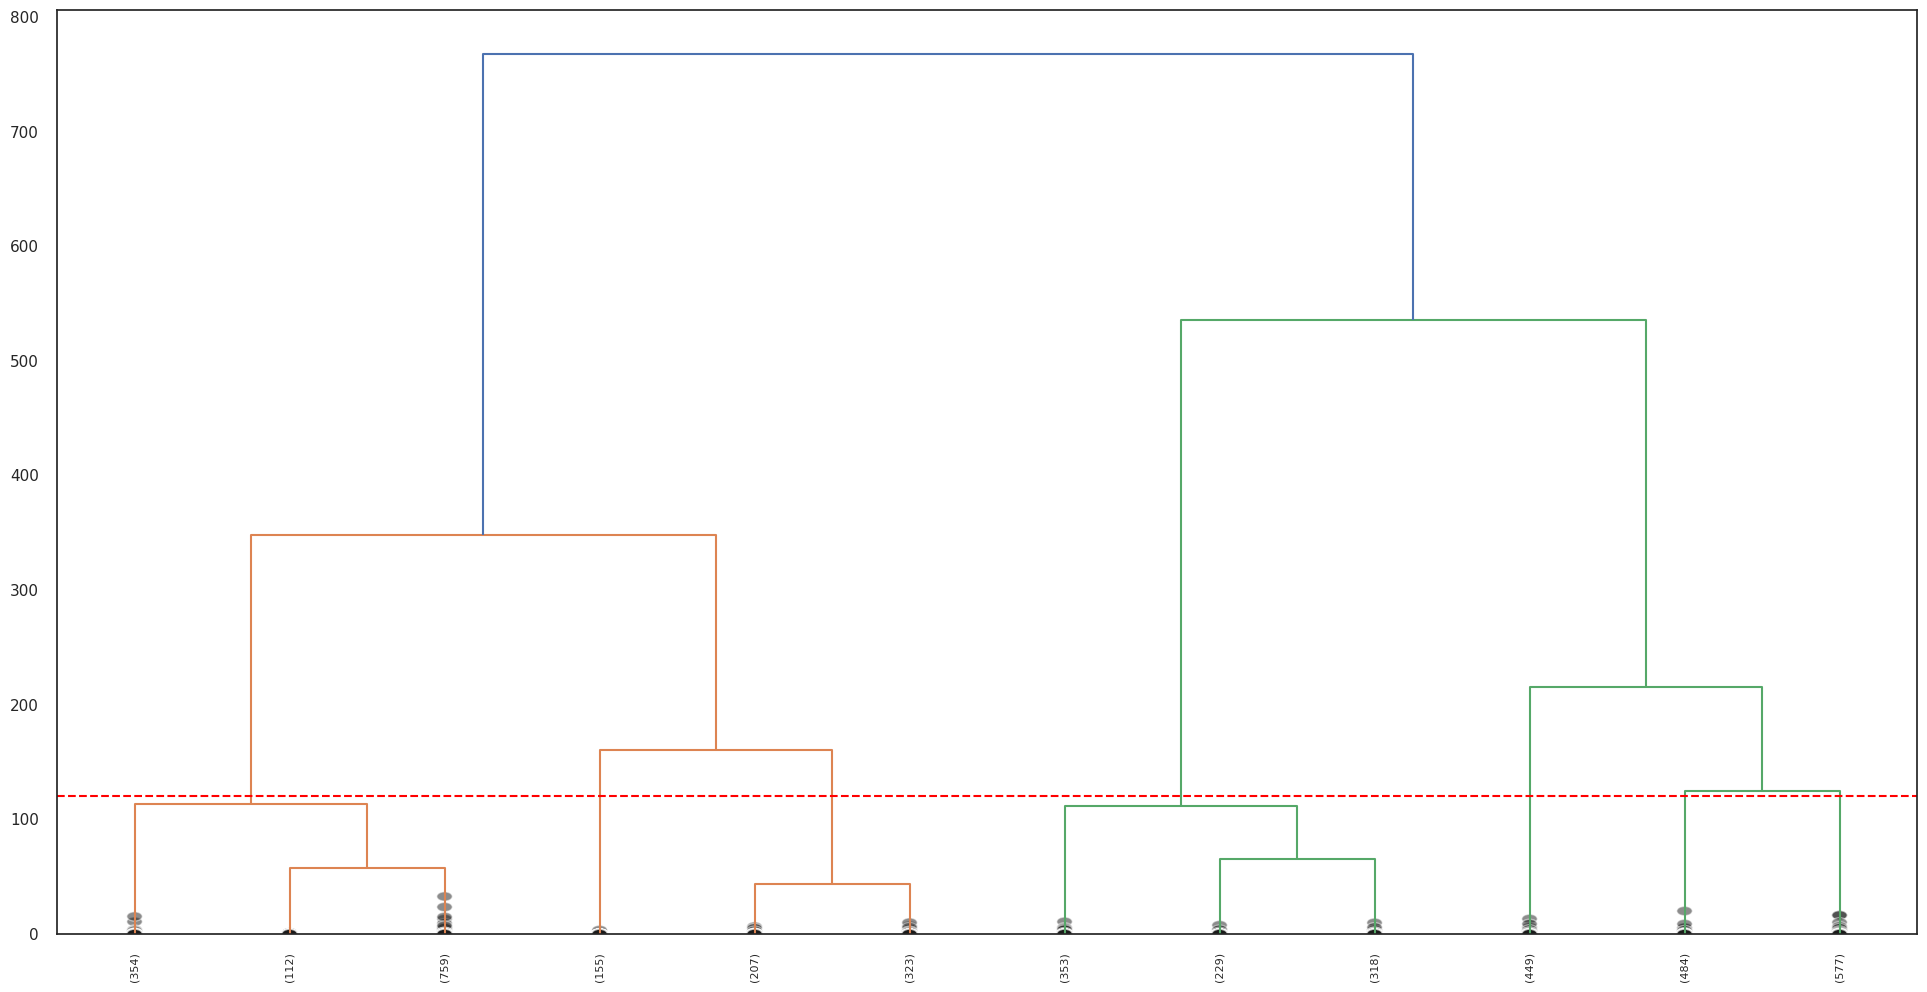

In [90]:
dendrogram( 
   model,
   truncate_mode='lastp',
   p=12,
   leaf_rotation=90,
   leaf_font_size=8,
   show_contracted=True
)

plt.axhline(120, color='red', linestyle='--')
plt.show()

## <font color='darkorange'> 8.4. DBSCAN </font>
DBSCAN stands for density-based spatial clustering of applications with noise. It's a density-based clustering algorithm. It is able to find irregular-shaped clusters. It separates regions by areas of low-density so it can also detect outliers really well. This algorithm is better than k-means when it comes to working with oddly shaped data.

**Parameters**

**eps** : float, default=0.

    The maximum distance between two samples for one to be considered
    as in the neighborhood of the other. This is not a maximum bound
    on the distances of points within a cluster. This is the most
    important DBSCAN parameter to choose appropriately for your data set
    and distance function.

**min_samples** : int, default=5

    The number of samples (or total weight) in a neighborhood for a point
    to be considered as a core point. This includes the point itself.


To determine the optimal parameters for DBSCAN, I utilized the **gp_minimize** function.

**gp_minimize** is a feature of the Scikit-optimize library that employs Bayesian optimization by fitting Gaussian regression models. This algorithm aims to discover the global minimum of an objective function within a defined search space based on the input variable constraints.


In this case, I created a custom function that takes the eps and min_samples parameters and maximizes the silhouette score metric. The silhouette score evaluates the quality of clustering by measuring the coherence within clusters and the separation between clusters.


By using **gp_minimize**, I performed an intelligent search to find the values of eps and min_samples that yield the highest silhouette score, indicating the optimal parameters for the DBSCAN algorithm.

In [91]:
data = df_umap.copy()

In [92]:
def training_model(params):
    eps = params[0]
    min_samples = params[1]

    print(params, '\n')
    
    dbscan_model = DBSCAN( eps=eps, min_samples=min_samples )
    labels = dbscan_model.fit_predict( data )
    ss_score = silhouette_score(data, labels=labels, metric='euclidean')
    
    return -ss_score

In [93]:
space = [(0.01, 5), # eps
         (4, 50)] # min_samples

In [94]:
resultados_gp = gp_minimize(training_model, space, random_state=0, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
[2.968294644942842, 43] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2391
Function value obtained: -0.6866
Current minimum: -0.6866
Iteration No: 2 started. Evaluating function at random point.
[4.291148631937557, 43] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2401
Function value obtained: -0.6170
Current minimum: -0.6866
Iteration No: 3 started. Evaluating function at random point.
[3.1215828469620024, 22] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2293
Function value obtained: -0.6866
Current minimum: -0.6866
Iteration No: 4 started. Evaluating function at random point.
[1.494697686656917, 7] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2198
Function value obtained: -0.6612
Current minimum: -0.6866
Iteration No: 5 started. Evaluating function at random point.
[1.3705549099547651, 26] 

Iteration No: 5 ended. Eval

In [95]:
resultados_gp.x

[2.968294644942842, 43]

[0 1 2 3 4]


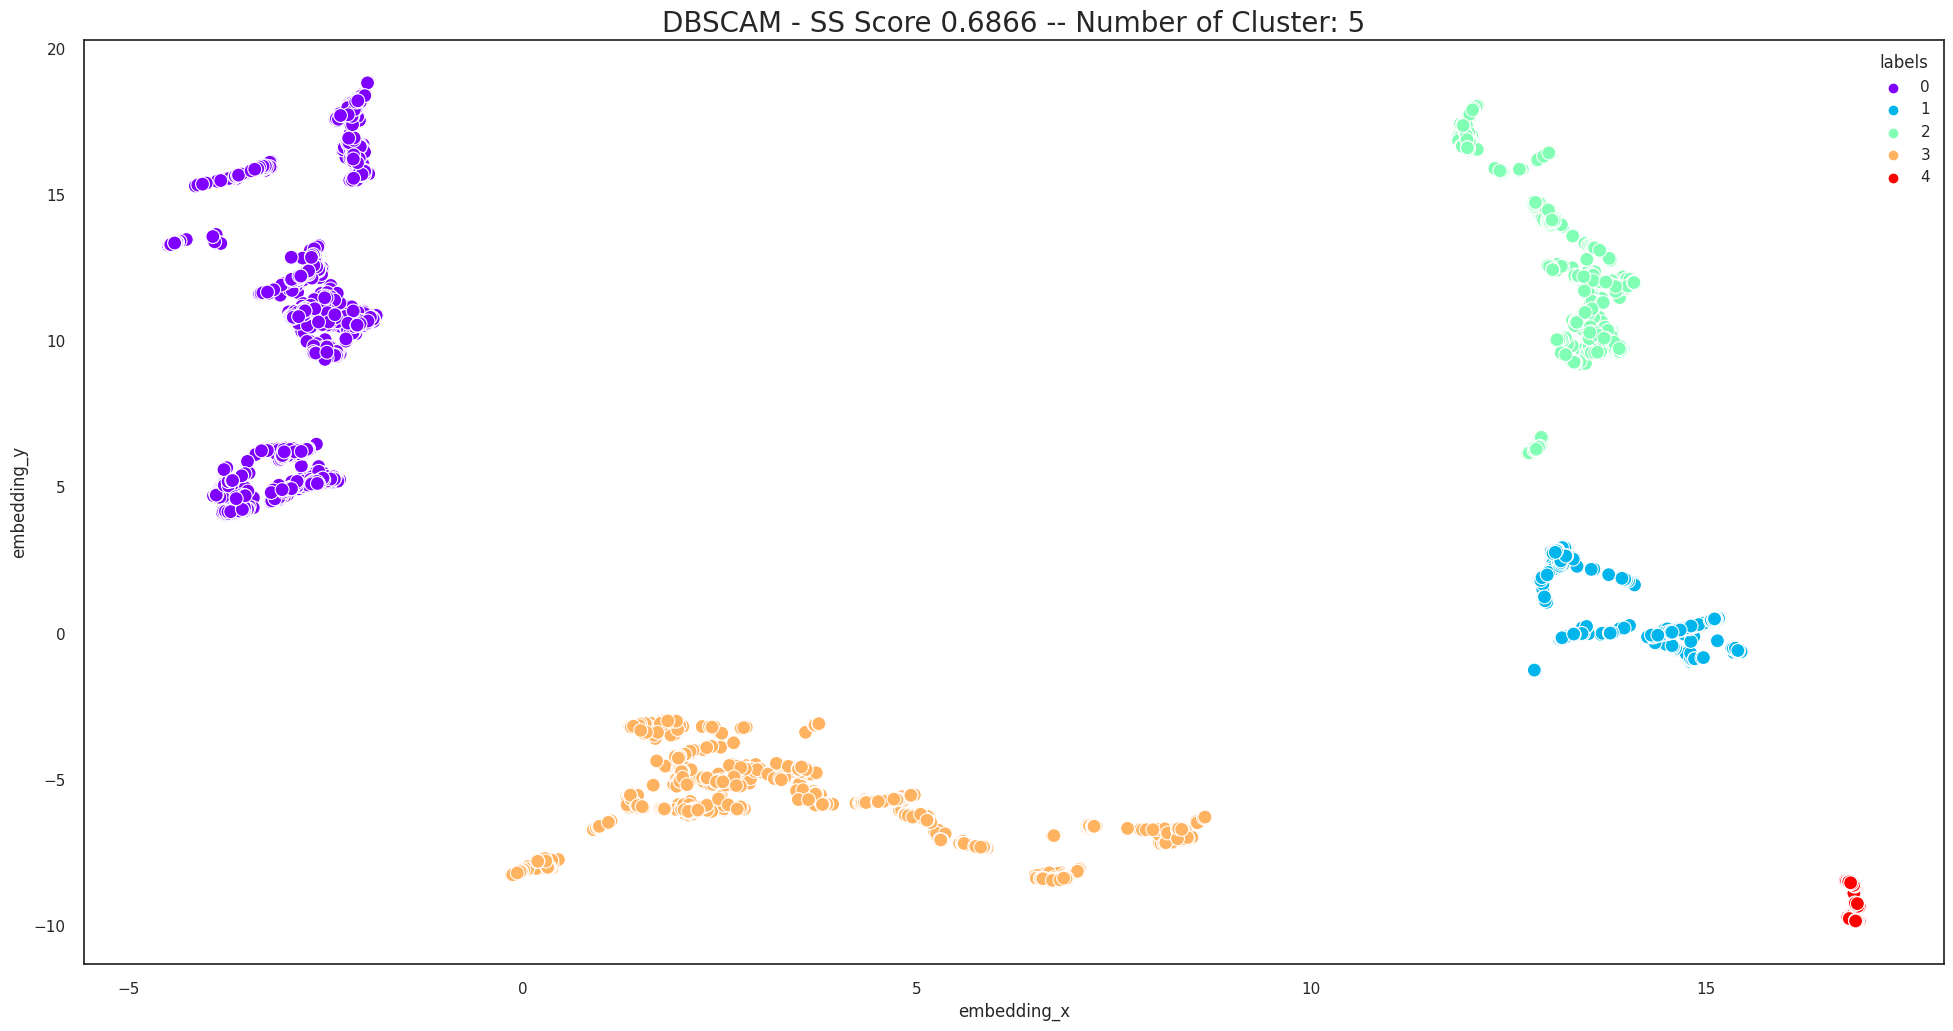

In [96]:
data = df_umap.copy()

# Set parameters
eps = 3
min_samples = 45

# model definition
dbscan_model = DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( data )
ss_score = silhouette_score(data, labels=labels, metric='euclidean')

data['labels'] = labels
cluster = data.labels.nunique()

print(data.labels.unique())

sns.scatterplot(data=data,x='embedding_x', y='embedding_y', hue='labels', palette='rainbow', s=100);
plt.title(f"DBSCAM - SS Score {ss_score:.4f} -- Number of Cluster: {cluster}", fontsize=20);

# <font color='darkorange'> 9.0. Model Training </font>
With the results of the algorithms above, we need to choose the best algorithms and parameters.

| <font color='lighblue'>Algorithm | <font color='lighblue'>Number of Cluster | <font color='lighblue'>Silhoette Score|
| -- | -- | -- |
|KMeans| 7| 0.7116 |
|GMM| 8 | 0.6634 |
|HClustering| 7 | 0.7092 |
|DBSCAN| 5 | 0.6866 |

For the company, having 7 clusters is considered optimal for marketing planning strategies. Additionally, the best scores were achieved using 7 clusters. Therefore, both KMeans and HClustering were considered, but KMeans was chosen not only because it had the best Silhouette Score, but also because it is a faster algorithm.

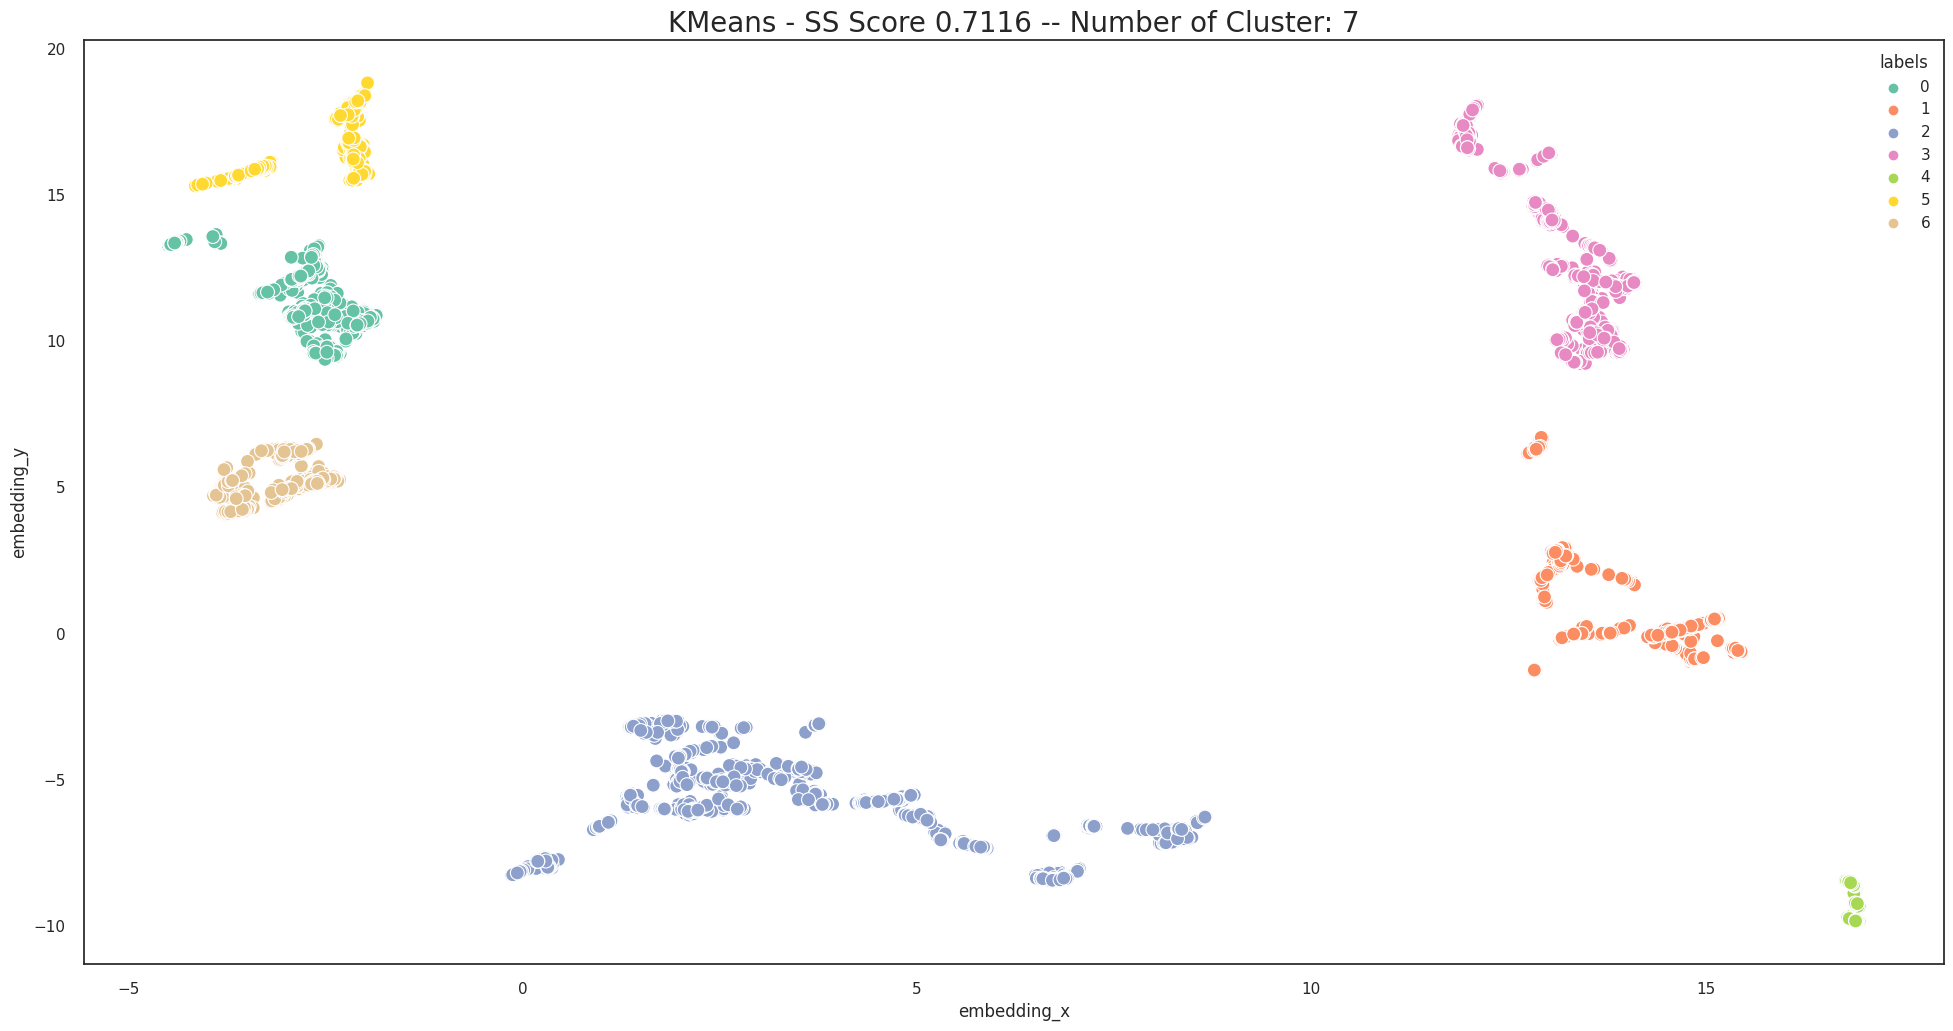

In [97]:
data = df_umap.copy()
model = KMeans(init="k-means++", random_state=0, n_clusters=7)
model.fit(data)
labels = model.predict(data)
ss_score = silhouette_score(data, labels=labels, metric='euclidean')

data['labels'] = labels
cluster = data.labels.nunique()

sns.scatterplot(data=data,x='embedding_x', y='embedding_y', hue='labels', palette='Set2', s=100);
plt.title(f"KMeans - SS Score {ss_score:.4f} -- Number of Cluster: {cluster}", fontsize=20);

# <font color='darkorange'> 10.0. Cluster Analysis </font>
Once the clustering algorithm has produced its results, it is crucial to analyze the clusters and understand their characteristics. This involves examining the types of clients present in each cluster and understanding the behavior exhibited by each cluster.

By analyzing the clusters, we can gain insights into the different segments or groups of clients that exist within the dataset. This analysis helps us understand the unique characteristics, preferences, and behaviors exhibited by each cluster.

Some important aspects to consider during cluster analysis include:

**Cluster Profiles**: Identify the defining characteristics of each cluster by examining the attributes or features that contribute most significantly to the separation of clusters. This helps in understanding the distinct traits of each cluster.

**Cluster Comparison**: Compare the clusters to identify similarities and differences between them. Look for patterns, trends, or common behaviors within each cluster and contrast them against other clusters.

**Cluster Interpretation**: Interpret the meaning behind each cluster. Assign meaningful labels or descriptions to each cluster based on the characteristics of the clients within them. This helps in understanding the types of clients that belong to each cluster.

In [98]:
df8 = df5.copy()
df8['cluster'] = labels
df8.head()

customer_id  lifetime  recency  avg_purchase_interval  frequency  number_products  nunique_products  avg_basket_size  purchase_count  charge_back_count  return_rate  avg_unt_price  avg_order_value  gross_revenue  cluster
0      17850.0     373.0    372.0              10.657143   0.093834            297.0              21.0        48.371429              35                1.0     0.028571       3.960370       151.103714        5288.63        5
1      13047.0     373.0     56.0              23.312500   0.042895            171.0             105.0        84.687500              16                7.0     0.437500       3.926082       193.068750        3089.10        0
2      12583.0     373.0      2.0              21.941176   0.045576            232.0             114.0       292.823529              17                2.0     0.117647       2.140474       389.961176        6629.34        5
3      13748.0     373.0     95.0              74.600000   0.013405             28.0              24.0        87.800000               5                0.0     0.000000       3.996429       189.650000         948.25        1
4      15100.0     373.0    333.0              62.166667   0.016086              3.0               1.0         9.666667               6                3.0     0.500000      10.950000       105.850000         635.10        3

## <font color='darkorange'> 10.1. Cluster Profile

In [99]:
clusters_info = (df8.groupby('cluster').agg({
                                             'cluster': lambda x: len(x),
                                             'customer_id': lambda x: np.round((len(x))/len(df8),3)})
                                             .rename(columns = {'cluster':'n_customer',
                                                                'customer_id':'perc_customer'}).reset_index())

customers_means = df8.drop(columns='customer_id').groupby('cluster').mean().reset_index()

clusters_info = clusters_info.merge(customers_means, how='left', on='cluster')

columns = ['cluster', 'n_customer', 'perc_customer', 'gross_revenue', 'recency', 'frequency', 'number_products', 
           'nunique_products', 'return_rate', 'avg_order_value', 'avg_basket_size', 'lifetime']

clusters_info = clusters_info[columns]

np.round(clusters_info[columns].sort_values('gross_revenue',ascending=False),2)

cluster  n_customer  perc_customer  gross_revenue  recency  frequency  number_products  nunique_products  return_rate  avg_order_value  avg_basket_size  lifetime
5        5         484           0.11        8875.20    22.19       0.06           420.24            223.26         0.14           566.14           321.55    308.88
0        0         577           0.13        2943.38    48.64       0.03           132.80             99.94         0.12           487.21           307.33    266.36
6        6         449           0.10        1611.53    58.47       0.03            87.61             70.60         0.12           335.93           210.38    245.33
2        2        1225           0.28         883.85    87.79       0.03            44.39             38.70         0.09           333.33           204.69    202.64
4        4         155           0.04         504.67   130.86       0.03            16.97             16.48         0.01           386.98           239.82    156.00
1        1         611           0.14         413.80   134.08       0.02            18.02             16.91         0.06           237.10           147.40    189.23
3        3         819           0.19         203.10   149.80       0.02            10.86             10.18         0.11           110.65            72.01    198.19

In [100]:
ordened_clusters = clusters_info.sort_values('gross_revenue',ascending=False).cluster.values
cluster_names = ["Insiders", "Loyals", "Potencials", "Medians", "Waitings", "Absentings", "Outs"]

map_cluster = dict(zip(ordened_clusters, cluster_names))
map_cluster

{5: 'Insiders',
 0: 'Loyals',
 6: 'Potencials',
 2: 'Medians',
 4: 'Waitings',
 1: 'Absentings',
 3: 'Outs'}

In [101]:
clusters_info.cluster = clusters_info.cluster.map(map_cluster)
df8.cluster = df8.cluster.map(map_cluster)

cluster  n_customer  perc_customer  gross_revenue     recency  frequency  number_products  nunique_products  return_rate  avg_order_value  avg_basket_size    lifetime
5    Insiders         484          0.112    8875.201178   22.190083   0.059499       420.241736        223.264463     0.142835       566.140266       321.552015  308.882231
0      Loyals         577          0.134    2943.378423   48.644714   0.032343       132.800693         99.941075     0.120866       487.208705       307.325543  266.358752
6  Potencials         449          0.104    1611.525702   58.472160   0.029572        87.605791         70.599109     0.123097       335.932176       210.375640  245.334076
2     Medians        1225          0.284     883.846163   87.791020   0.025248        44.385306         38.697143     0.090781       333.328035       204.685629  202.641633
4    Waitings         155          0.036     504.668516  130.858065   0.028264        16.974194         16.477419     0.009140       386.976319       239.815054  156.000000
1  Absentings         611          0.141     413.802160  134.076923   0.022035        18.021277         16.905074     0.061492       237.102389       147.396244  189.230769
3        Outs         819          0.190     203.100928  149.803419   0.021095        10.859585         10.177045     0.106088       110.653393        72.012903  198.185592

In [105]:
np.round(clusters_info.sort_values("gross_revenue", ascending=False),2)

cluster  n_customer  perc_customer  gross_revenue  recency  frequency  number_products  nunique_products  return_rate  avg_order_value  avg_basket_size  lifetime
5    Insiders         484           0.11        8875.20    22.19       0.06           420.24            223.26         0.14           566.14           321.55    308.88
0      Loyals         577           0.13        2943.38    48.64       0.03           132.80             99.94         0.12           487.21           307.33    266.36
6  Potencials         449           0.10        1611.53    58.47       0.03            87.61             70.60         0.12           335.93           210.38    245.33
2     Medians        1225           0.28         883.85    87.79       0.03            44.39             38.70         0.09           333.33           204.69    202.64
4    Waitings         155           0.04         504.67   130.86       0.03            16.97             16.48         0.01           386.98           239.82    156.00
1  Absentings         611           0.14         413.80   134.08       0.02            18.02             16.91         0.06           237.10           147.40    189.23
3        Outs         819           0.19         203.10   149.80       0.02            10.86             10.18         0.11           110.65            72.01    198.19

## <font color='darkorange'> 10.2. Cluster Comparison

In [102]:
# Select columns for comparison
cols = ['gross_revenue', 'recency', 'frequency', 'return_rate', 'number_products', 'nunique_products', 'avg_order_value', 'avg_basket_size', 'lifetime']

# Create a copy of the clusters_info DataFrame for comparison
comparison = clusters_info[['cluster'] + cols].copy()

# Apply MinMaxScaler to normalize the selected columns
scaler = MinMaxScaler()
comparison.recency = comparison.recency.sum() / comparison.recency
comparison[cols] = scaler.fit_transform(comparison[cols])

comparison = comparison.sort_values('gross_revenue', ascending=False)
comparison

cluster  gross_revenue   recency  frequency  return_rate  number_products  nunique_products  avg_order_value  avg_basket_size  lifetime
5    Insiders       1.000000  1.000000   1.000000     1.000000         1.000000          1.000000         1.000000         1.000000  1.000000
0      Loyals       0.315988  0.361602   0.292871     0.835676         0.297866          0.421254         0.826709         0.942989  0.721855
6  Potencials       0.162409  0.271602   0.220720     0.852362         0.187468          0.283555         0.494589         0.554473  0.584333
2     Medians       0.078498  0.122826   0.108131     0.610654         0.081893          0.133842         0.488872         0.531671  0.305082
4    Waitings       0.034774  0.025175   0.186673     0.000000         0.014936          0.029567         0.606654         0.672448  0.000000
1  Absentings       0.024296  0.020396   0.024477     0.391581         0.017494          0.031574         0.277613         0.302090  0.217362
3        Outs       0.000000  0.000000   0.000000     0.725140         0.000000          0.000000         0.000000         0.000000  0.275935

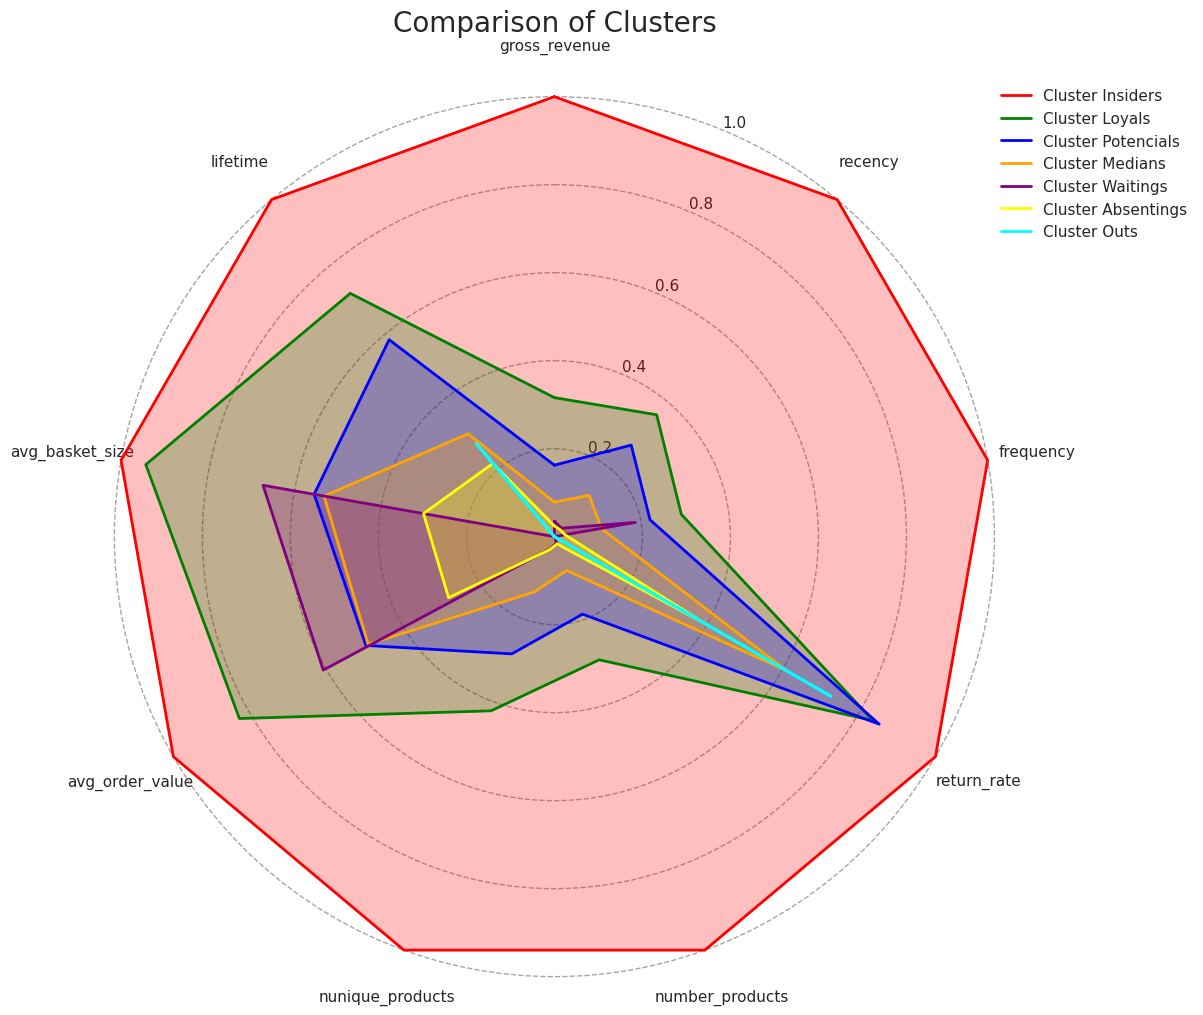

In [109]:
# Get the cluster names from the "cluster" column
cluster_names = comparison['cluster'].values

# Remove the 'cluster' column from the comparison dataset
comparison_data = comparison.drop('cluster', axis=1)
categories = comparison_data.columns

# Get the values for each cluster
clusters_data = comparison_data.values

# Calculate the means for each category in each cluster
means = np.mean(clusters_data, axis=0)

# Calculate the standard deviations for each category in each cluster
stds = np.std(clusters_data, axis=0)

# Calculate the number of clusters and categories
num_clusters = clusters_data.shape[0]
num_categories = clusters_data.shape[1]

# Create the angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()

# Ensure the first and last angles are the same to close the loop
angles += angles[:1]

# Create the radar plot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.spines['polar'].set_visible(False)
ax.xaxis.grid(False)
ax.yaxis.grid(True, color='gray', linestyle='--', alpha=0.7)

# Define custom colors for each cluster
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'cyan']

# Plot the radar chart for each cluster with custom colors
for i in range(num_clusters):
    values = clusters_data[i].tolist()
    values += values[:1]  # Repeat the first value to close the loop
    ax.plot(angles, values, linestyle='-', linewidth=2, color=colors[i], label=f'Cluster {cluster_names[i]}')
    ax.fill(angles, values, alpha=0.25, color=colors[i])

# Set the labels for each category
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Set the title and legend
ax.set_title('Comparison of Clusters', size=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the radar chart
plt.show()


# <font color='darkorange'> 11.1. Bussines Questions

### <font color='darkorange'> 1. Who are the customers eligible for the "insider" cluster?

In [110]:
df8.query("cluster == 'Insiders'")[['customer_id', 'cluster']]

customer_id   cluster
0         17850.0  Insiders
2         12583.0  Insiders
6         14688.0  Insiders
8         15311.0  Insiders
12        16029.0  Insiders
...           ...       ...
4029      12357.0  Insiders
4068      15531.0  Insiders
4273      13521.0  Insiders
4310      16000.0  Insiders
4311      15195.0  Insiders

[484 rows x 2 columns]

### <font color='darkorange'> 2. How many customers are gonna be Insiders?

In [111]:
clusters_info[['cluster', 'n_customer', 'perc_customer']]

cluster  n_customer  perc_customer
0      Loyals         577          0.134
1  Absentings         611          0.141
2     Medians        1225          0.284
3        Outs         819          0.190
4    Waitings         155          0.036
5    Insiders         484          0.112
6  Potencials         449          0.104

### <font color='darkorange'> 3. What are the principal features of Insiders?

- gross revenue
- recency
- frequency
- number products
- nunique products
- return rate
- avg order value
- avg basket size
- lifetime

### <font color='darkorange'> 4. What percentage of revenue contribution do Insiders contribute?

In [112]:
purchases = df3.copy()
purchases['gross_revenue'] = purchases.quantity * purchases.unit_price
purchases = purchases.query('gross_revenue > 0')

purchases = purchases.merge(df8[['customer_id', 'cluster']], on='customer_id', how='left')

purchases = purchases.dropna()
purchases = purchases.groupby('cluster')[['gross_revenue']].sum().reset_index()

purchases.head()

cluster  gross_revenue
0  Absentings      256066.35
1    Insiders     4407753.80
2      Loyals     1745692.51
3     Medians     1103195.20
4        Outs      346046.11

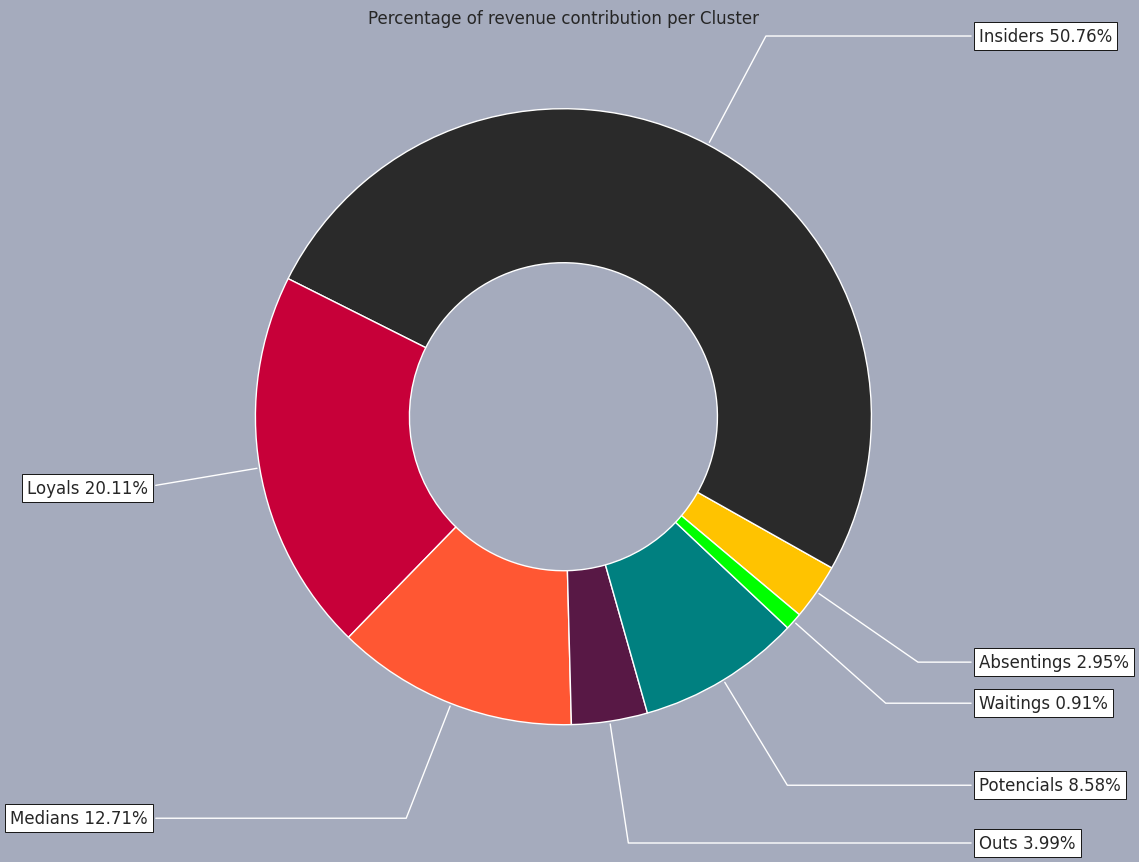

In [113]:
aux = purchases[['cluster', 'gross_revenue']]
aux.gross_revenue = aux.gross_revenue/(purchases.gross_revenue.sum())

palette = ["#FFC300", # (Amarelo)       - - - ABSENTINGS
           "#2A2A2A", # (Preto)       - - - INSIDERS
           "#C70039", # (Vermelho)      - - - LOYALS
           "#FF5733", # (Laranja)          - - - MEDIANS
           "#581845", # (Roxo Escuro)   - - - OUTS
           "#008080", # (Verde Azulado) - - - POTENCIALS
           "#00FF00"] # (Verde)         - - - WAITINGS

fig, ax = plt.subplots(figsize = (10, 10), facecolor = "#A5ABBD")

wedges, texts = ax.pie(aux.gross_revenue, wedgeprops=dict(width=0.5), startangle=-40, normalize=True, colors=palette);


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(aux.cluster.iloc[i] + " " + str(round(aux.gross_revenue.iloc[i] * 100, 2)) + "%", xy=(x, y), 
                xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)

plt.title("Percentage of revenue contribution per Cluster")
plt.show();

### <font color='darkorange'> 5. What products are most used by Insiders?

In [114]:
purchases = df3.copy()
purchases = purchases.merge(df8[['customer_id', 'cluster']], on='customer_id', how='left')
insiders = purchases.query("cluster == 'Insiders'")

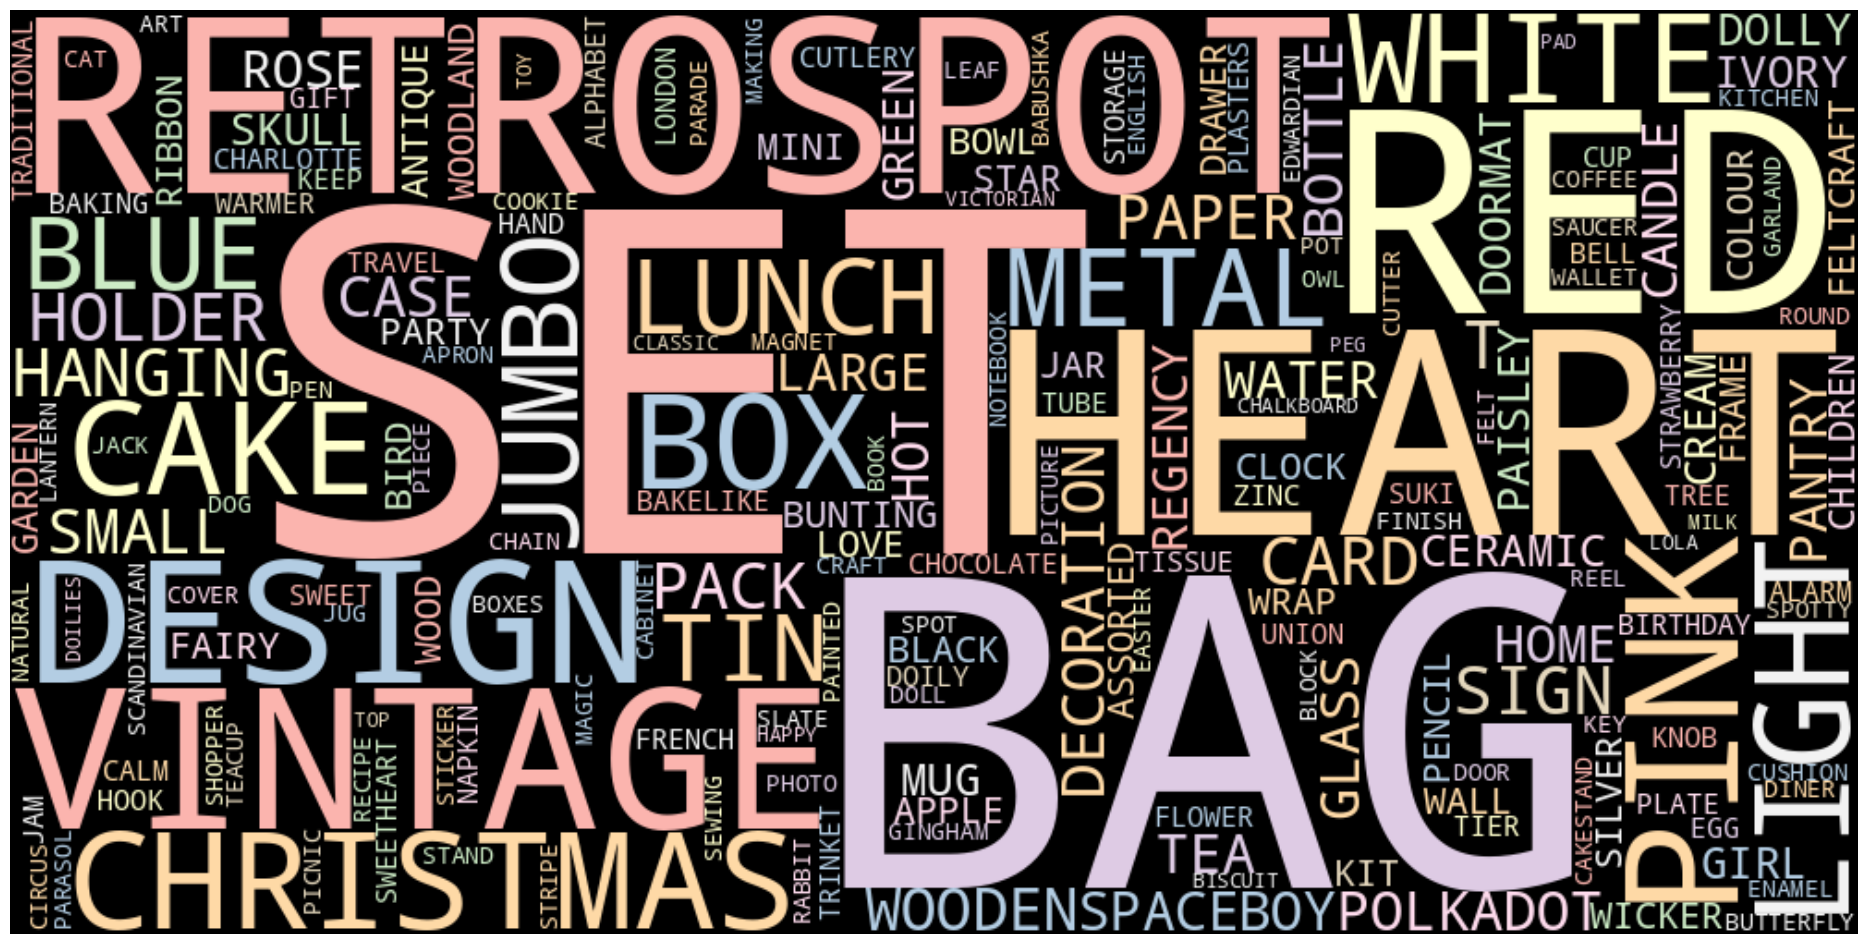

In [115]:
#Creating the text variable
text = " ".join(cat for cat in purchases.description)

# Create the wordcloud object
wordcloud = WordCloud(
        width=1000,
        height=500,
        random_state=1,
        background_color="black",
        colormap="Pastel1",
        collocations=False,
        stopwords=STOPWORDS,
        ).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()